In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
def download_link(url):
  '''Method reformates the share link from Google Drive into fetchable form'''
  return 'https://drive.google.com/uc?id=' + url.split('/')[-2]

In [4]:
data = pd.read_csv(download_link("https://drive.google.com/file/d/15eHai6zkPwOBMq59n8uIjjohuuiaV8DF/view?usp=sharing"))

In [6]:
# dataset does not contain missing values
data.isna().sum()

NAZOV              0
ZEMEPISNA_SIRKA    0
ZEMEPISNA_DLZKA    0
SMER_DO            0
SMER_Z             0
DATUM_A_CAS        0
POCET_DO           0
POCET_Z            0
ObjectId           0
dtype: int64

In [7]:
def clean_data(data):
    '''Removes unnecessary columns, creates datetime index and total cyclists column'''
    data = data.copy()
    data["date_time"] = pd.to_datetime(data["DATUM_A_CAS"], errors="coerce")
    data["cyclists_total"] = data["POCET_DO"] + data["POCET_Z"]
    data = data.rename(columns={"NAZOV": "name", "POCET_DO": "direction_to", "POCET_Z": "direction_from"})


    columns = ["name", "date_time", "cyclists_total", "direction_to", "direction_from"]
    data = data[columns]
    return data

In [8]:
data = clean_data(data)

In [9]:
data

name                 date_time  cyclists_total  \
0       #11 - Most Apollo 2025-04-22 23:00:00+00:00               0   
1       #11 - Most Apollo 2025-04-22 22:00:00+00:00               0   
2       #11 - Most Apollo 2025-04-22 21:00:00+00:00               0   
3       #11 - Most Apollo 2025-04-22 20:00:00+00:00               0   
4       #11 - Most Apollo 2025-04-22 19:00:00+00:00               0   
...                   ...                       ...             ...   
691171  Devinska Nova Ves 2025-12-15 18:00:00+00:00               0   
691172  Devinska Nova Ves 2025-12-15 19:00:00+00:00               0   
691173  Devinska Nova Ves 2025-12-15 20:00:00+00:00               1   
691174  Devinska Nova Ves 2025-12-15 21:00:00+00:00               0   
691175  Devinska Nova Ves 2025-12-15 22:00:00+00:00               0   

        direction_to  direction_from  
0                  0               0  
1                  0               0  
2                  0               0  
3                  0               0  
4                  0               0  
...              ...             ...  
691171             0               0  
691172             0               0  
691173             0               1  
691174             0               0  
691175             0               0  

[691176 rows x 5 columns]

In [10]:
data['name'].value_counts()

name
Cyklomost Slobody            95031
Hradza Berg                  93837
Viedenska                    93745
Devinska Nova Ves            52273
#4 - Dolnozemská             28822
#3 - River Park              28820
#1 - Starý Most              28794
#8 - Most SNP                24810
#9 - Páričkova               24807
#6 - Vajnorská               24806
#10 - Dunajská               24382
#12 - Železná studnička      24376
#2 - Starý most 2            23880
#7 - Vajnorská > NTC         23528
#5 - Devínska cesta          23188
#11 - Most Apollo            20467
#14 - Vajanského 2           16563
#13 - Vajanského 1           16551
#17 - Dunajská/Lazaretská     7500
#15 - Incheba Einsteinova     7498
#16 - Trenčianska             7498
Name: count, dtype: int64

In [11]:
def create_features(df):
    """Create time series features based on time index."""
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    # cyclic notation for day of the week
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek']/7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek']/7)
    #is weekend
    df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
    # spring/fall/summer/winter
    df['is_spring'] = df['month'].isin([3,4,5]).astype(int)
    df['is_summer'] = df['month'].isin([6,7,8]).astype(int)
    df['is_fall'] = df['month'].isin([9,10,11]).astype(int)
    df['is_winter'] = df['month'].isin([12,1,2]).astype(int)

    return df

In [12]:
data_with_features = create_features(data.set_index('date_time'))

In [13]:
data_with_features

name  cyclists_total  direction_to  \
date_time                                                                    
2025-04-22 23:00:00+00:00  #11 - Most Apollo               0             0   
2025-04-22 22:00:00+00:00  #11 - Most Apollo               0             0   
2025-04-22 21:00:00+00:00  #11 - Most Apollo               0             0   
2025-04-22 20:00:00+00:00  #11 - Most Apollo               0             0   
2025-04-22 19:00:00+00:00  #11 - Most Apollo               0             0   
...                                      ...             ...           ...   
2025-12-15 18:00:00+00:00  Devinska Nova Ves               0             0   
2025-12-15 19:00:00+00:00  Devinska Nova Ves               0             0   
2025-12-15 20:00:00+00:00  Devinska Nova Ves               1             0   
2025-12-15 21:00:00+00:00  Devinska Nova Ves               0             0   
2025-12-15 22:00:00+00:00  Devinska Nova Ves               0             0   

                           direction_from  hour  dayofweek  quarter  month  \
date_time                                                                    
2025-04-22 23:00:00+00:00               0    23          1        2      4   
2025-04-22 22:00:00+00:00               0    22          1        2      4   
2025-04-22 21:00:00+00:00               0    21          1        2      4   
2025-04-22 20:00:00+00:00               0    20          1        2      4   
2025-04-22 19:00:00+00:00               0    19          1        2      4   
...                                   ...   ...        ...      ...    ...   
2025-12-15 18:00:00+00:00               0    18          0        4     12   
2025-12-15 19:00:00+00:00               0    19          0        4     12   
2025-12-15 20:00:00+00:00               1    20          0        4     12   
2025-12-15 21:00:00+00:00               0    21          0        4     12   
2025-12-15 22:00:00+00:00               0    22          0        4     12   

                           year  dayofyear  dayofweek_sin  dayofweek_cos  \
date_time                                                                  
2025-04-22 23:00:00+00:00  2025        112       0.781831        0.62349   
2025-04-22 22:00:00+00:00  2025        112       0.781831        0.62349   
2025-04-22 21:00:00+00:00  2025        112       0.781831        0.62349   
2025-04-22 20:00:00+00:00  2025        112       0.781831        0.62349   
2025-04-22 19:00:00+00:00  2025        112       0.781831        0.62349   
...                         ...        ...            ...            ...   
2025-12-15 18:00:00+00:00  2025        349       0.000000        1.00000   
2025-12-15 19:00:00+00:00  2025        349       0.000000        1.00000   
2025-12-15 20:00:00+00:00  2025        349       0.000000        1.00000   
2025-12-15 21:00:00+00:00  2025        349       0.000000        1.00000   
2025-12-15 22:00:00+00:00  2025        349       0.000000        1.00000   

                           is_weekend  is_spring  is_summer  is_fall  \
date_time                                                              
2025-04-22 23:00:00+00:00           0          1          0        0   
2025-04-22 22:00:00+00:00           0          1          0        0   
2025-04-22 21:00:00+00:00           0          1          0        0   
2025-04-22 20:00:00+00:00           0          1          0        0   
2025-04-22 19:00:00+00:00           0          1          0        0   
...                               ...        ...        ...      ...   
2025-12-15 18:00:00+00:00           0          0          0        0   
2025-12-15 19:00:00+00:00           0          0          0        0   
2025-12-15 20:00:00+00:00           0          0          0        0   
2025-12-15 21:00:00+00:00           0          0          0        0   
2025-12-15 22:00:00+00:00           0          0          0        0   

                           is_winter  
date_time                             
2025-0

### By Hour

In [26]:
plt.style.use('default')

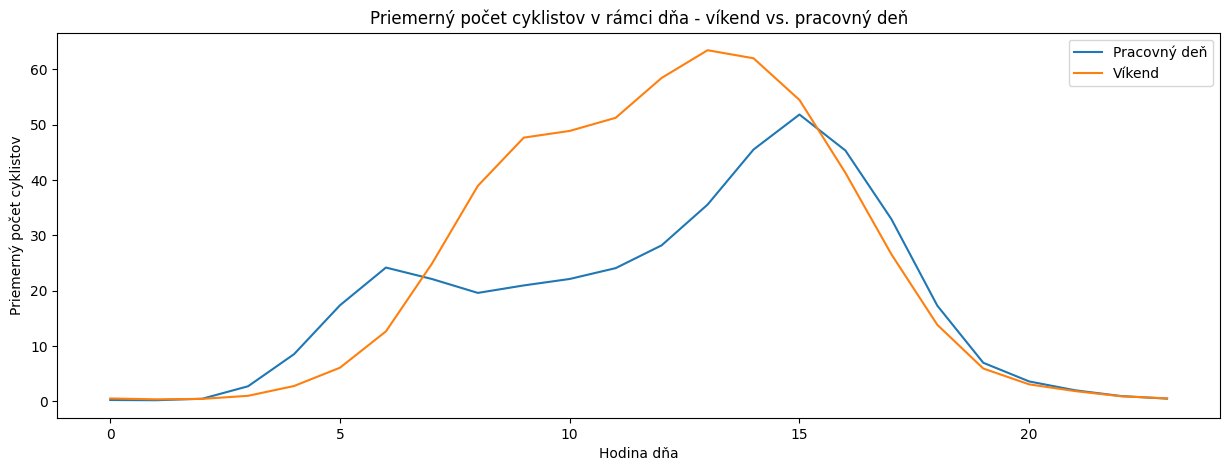

In [16]:
#separately for working days and weekends
plt.figure(figsize=(15,5), facecolor='white')
avg_by_hour_weekday = data_with_features[data_with_features['is_weekend'] == 0].groupby("hour")["cyclists_total"].mean()
avg_by_hour_weekend = data_with_features[data_with_features['is_weekend'] == 1].groupby("hour")["cyclists_total"].mean()
plt.plot(
    avg_by_hour_weekday.index,
    avg_by_hour_weekday.values,
    label='Pracovný deň'
)
plt.plot(
    avg_by_hour_weekend.index,
    avg_by_hour_weekend.values,
    label='Víkend'
)
plt.xlabel("Hodina dňa")
plt.ylabel("Priemerný počet cyklistov")
plt.title("Priemerný počet cyklistov v rámci dňa - víkend vs. pracovný deň")

plt.legend()
plt.show()

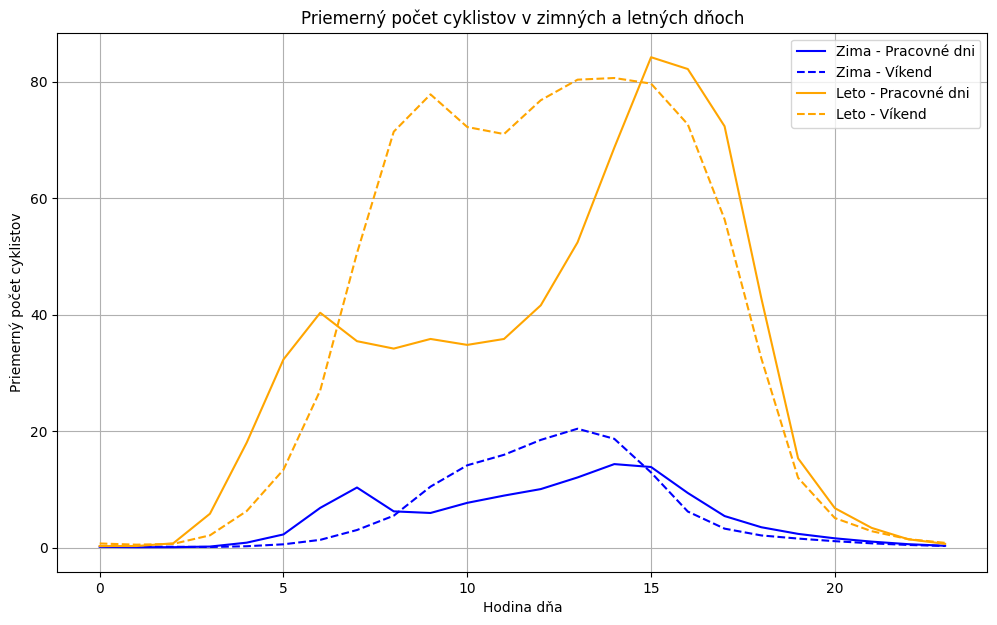

In [30]:
# Priemerný počet cyklistov pre zimné pracovné dni podľa hodiny
winter_weekday = (
    data_with_features[(data_with_features['is_winter'] == 1) & (data_with_features['is_weekend'] == 0)]
    .groupby("hour")["cyclists_total"]
    .mean()
)

# Priemerný počet cyklistov pre zimné víkendy podľa hodiny
winter_weekend = (
    data_with_features[(data_with_features['is_winter'] == 1) & (data_with_features['is_weekend'] == 1)]
    .groupby("hour")["cyclists_total"]
    .mean()
)

# Priemerný počet cyklistov pre letné pracovné dni podľa hodiny
summer_weekday = (
    data_with_features[(data_with_features['is_summer'] == 1) & (data_with_features['is_weekend'] == 0)]
    .groupby("hour")["cyclists_total"]
    .mean()
)

# Priemerný počet cyklistov pre letné víkendy podľa hodiny
summer_weekend = (
    data_with_features[(data_with_features['is_summer'] == 1) & (data_with_features['is_weekend'] == 1)]
    .groupby("hour")["cyclists_total"]
    .mean()
)

plt.figure(figsize=(12, 7))

plt.plot(winter_weekday.index, winter_weekday.values, label="Zima - Pracovné dni", color="blue", linestyle='-')
plt.plot(winter_weekend.index, winter_weekend.values, label="Zima - Víkend", color="blue", linestyle='--')

plt.plot(summer_weekday.index, summer_weekday.values, label="Leto - Pracovné dni", color="orange", linestyle='-')
plt.plot(summer_weekend.index, summer_weekend.values, label="Leto - Víkend", color="orange", linestyle='--')

plt.xlabel("Hodina dňa")
plt.ylabel("Priemerný počet cyklistov")
plt.title("Priemerný počet cyklistov v zimných a letných dňoch")
plt.legend()
plt.grid(True)
plt.show()


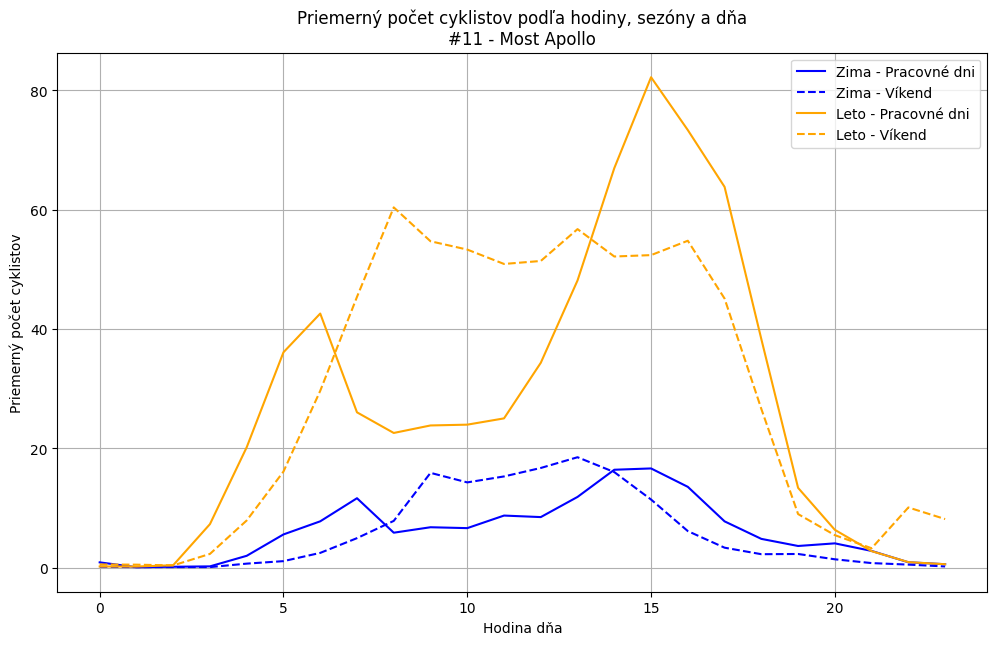

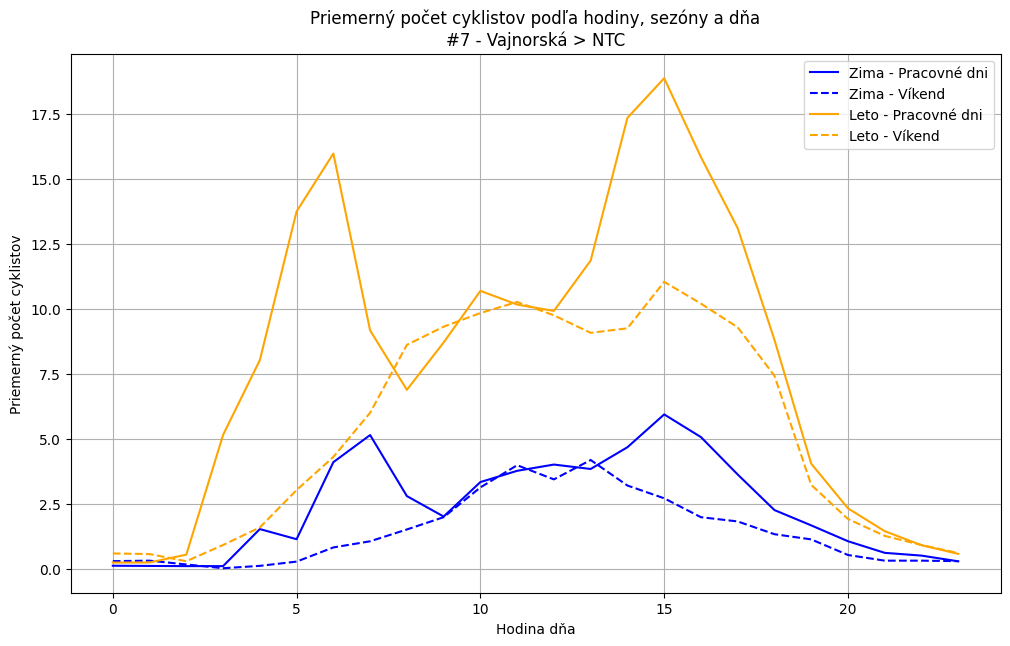

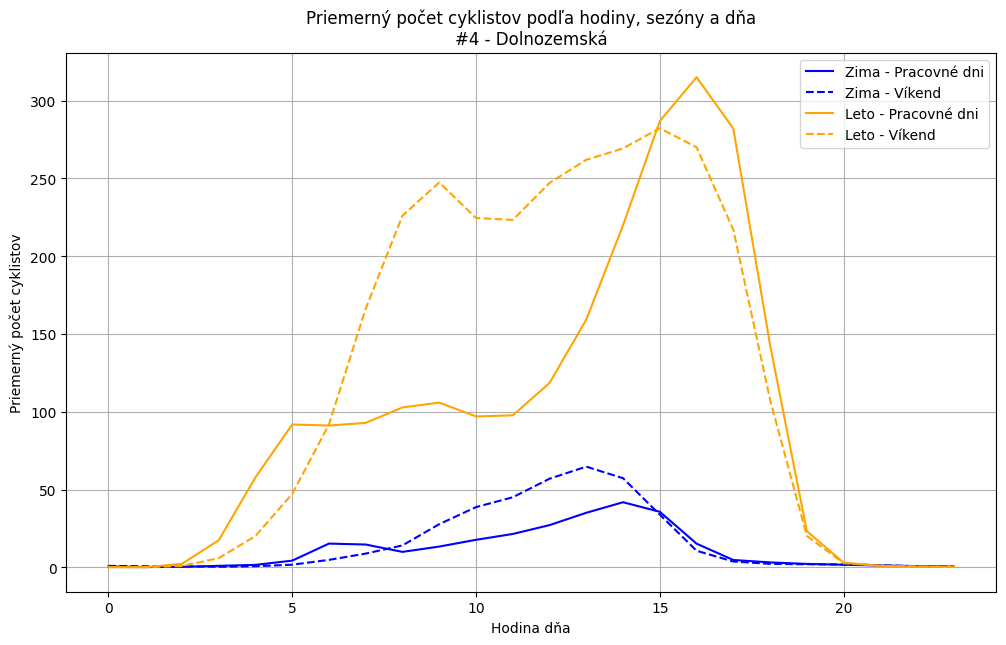

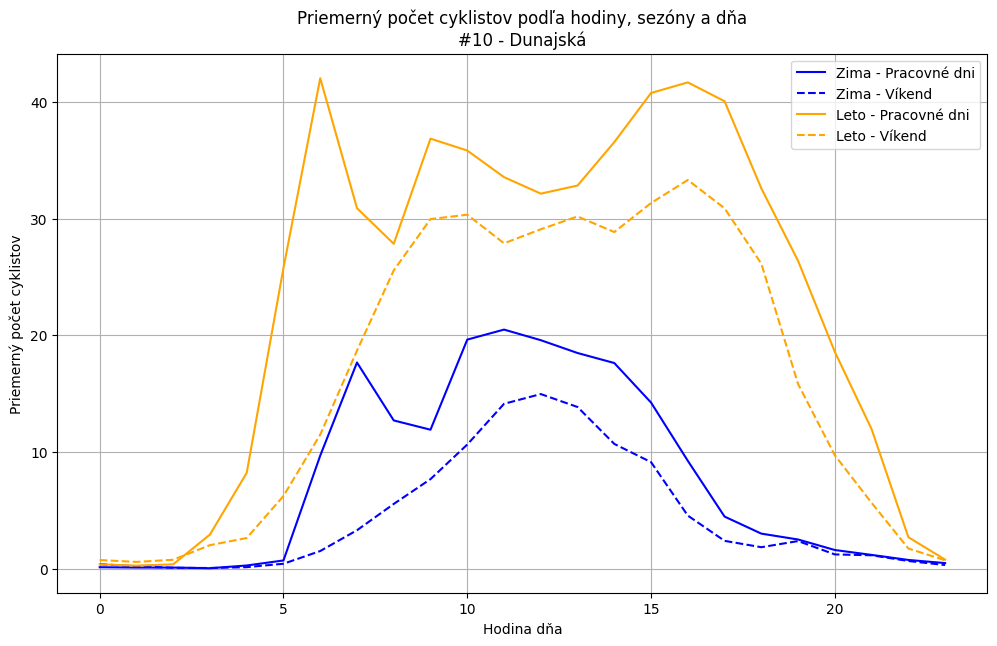

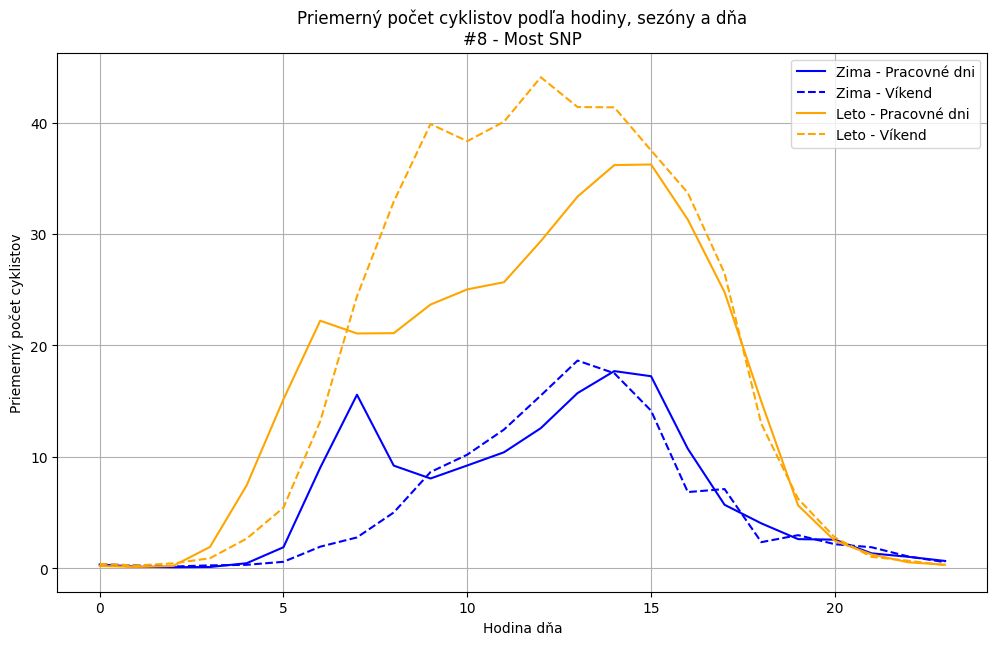

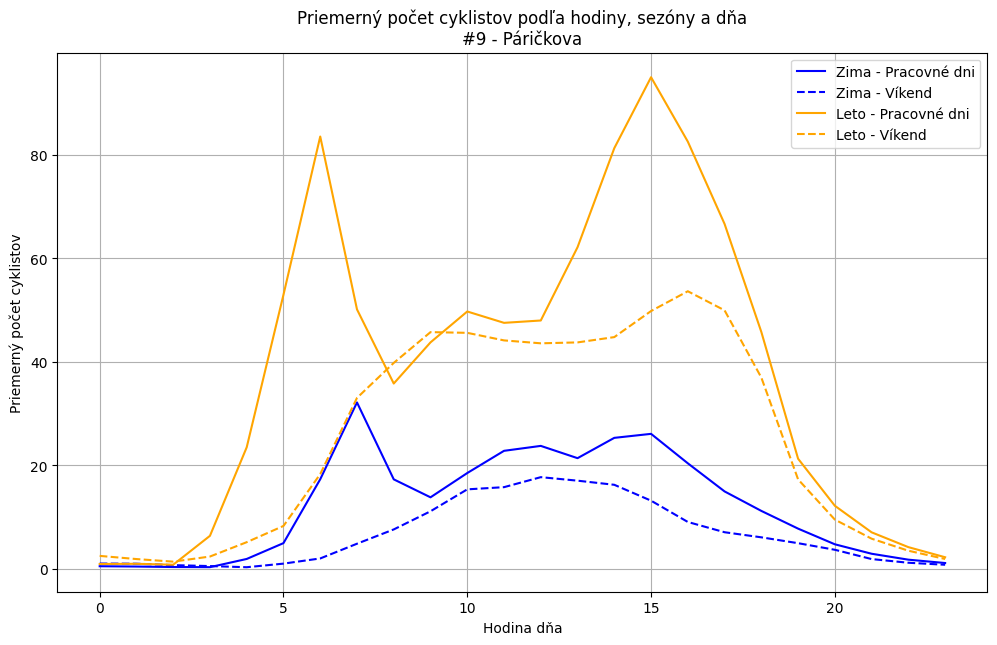

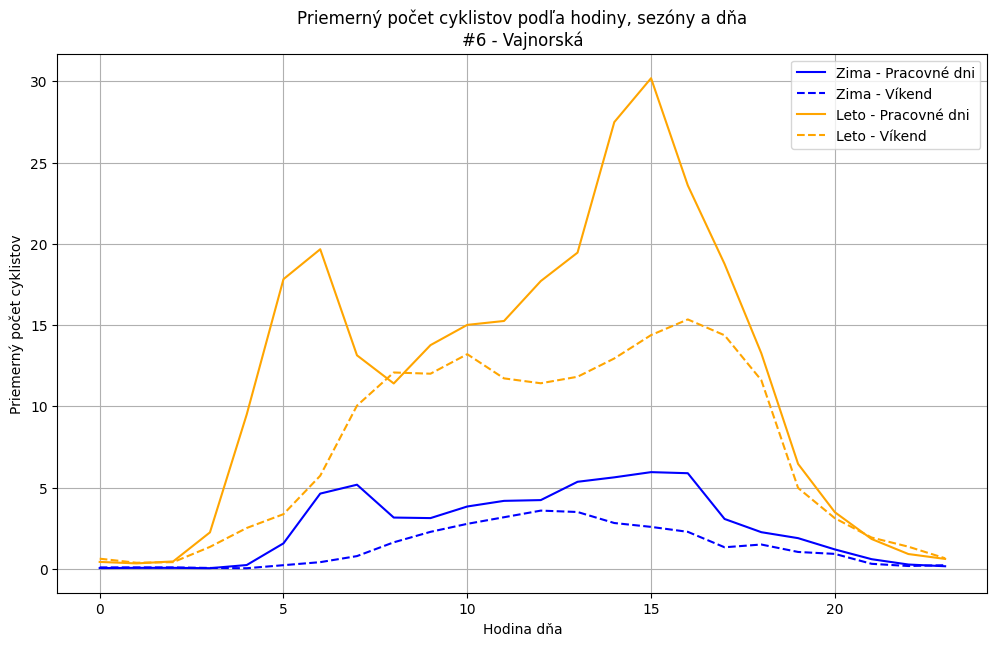

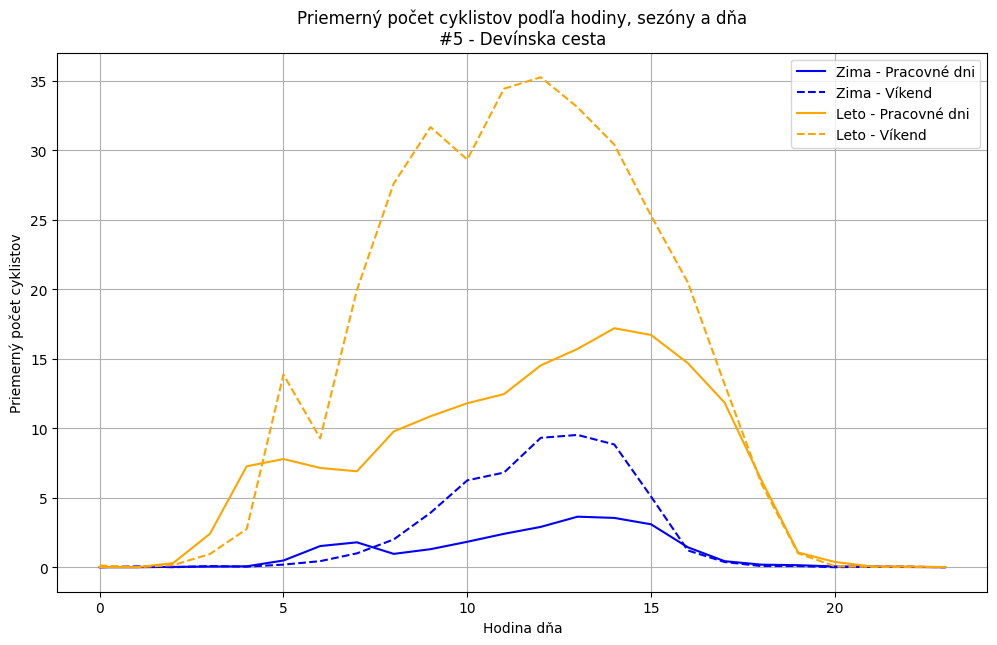

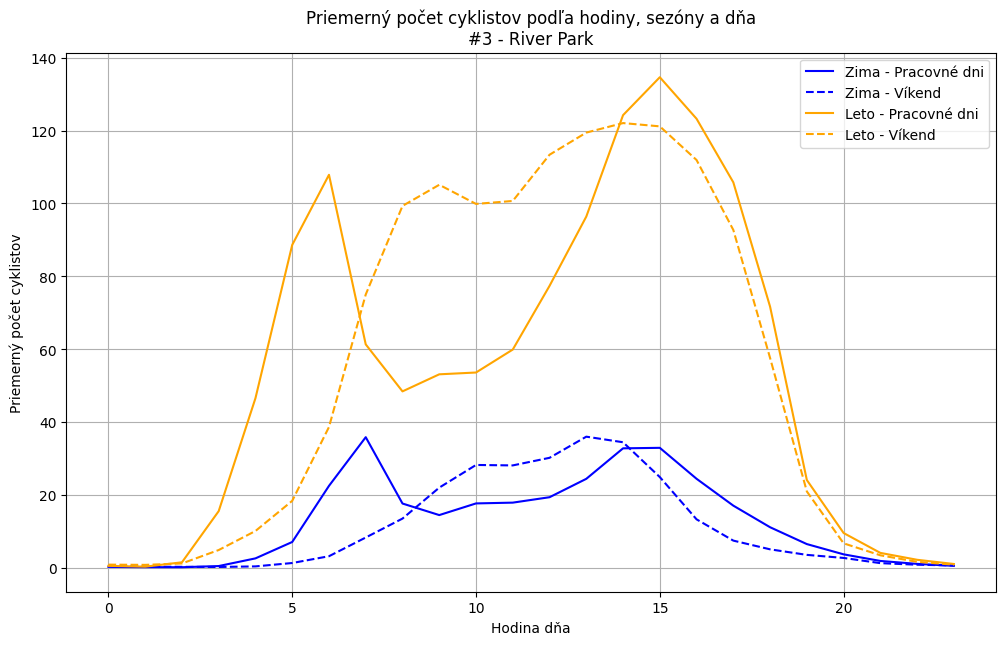

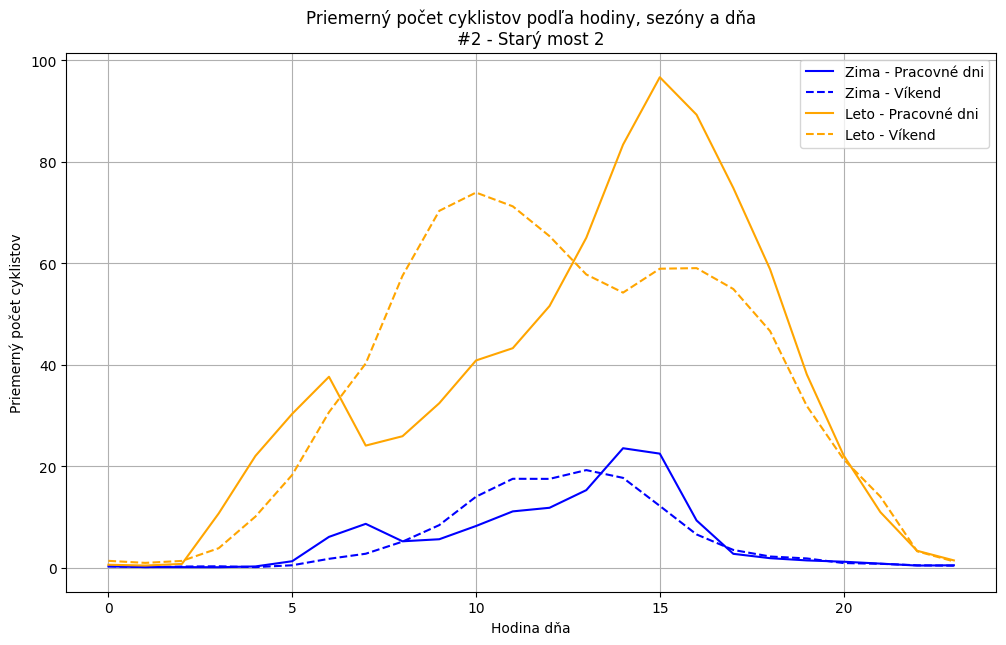

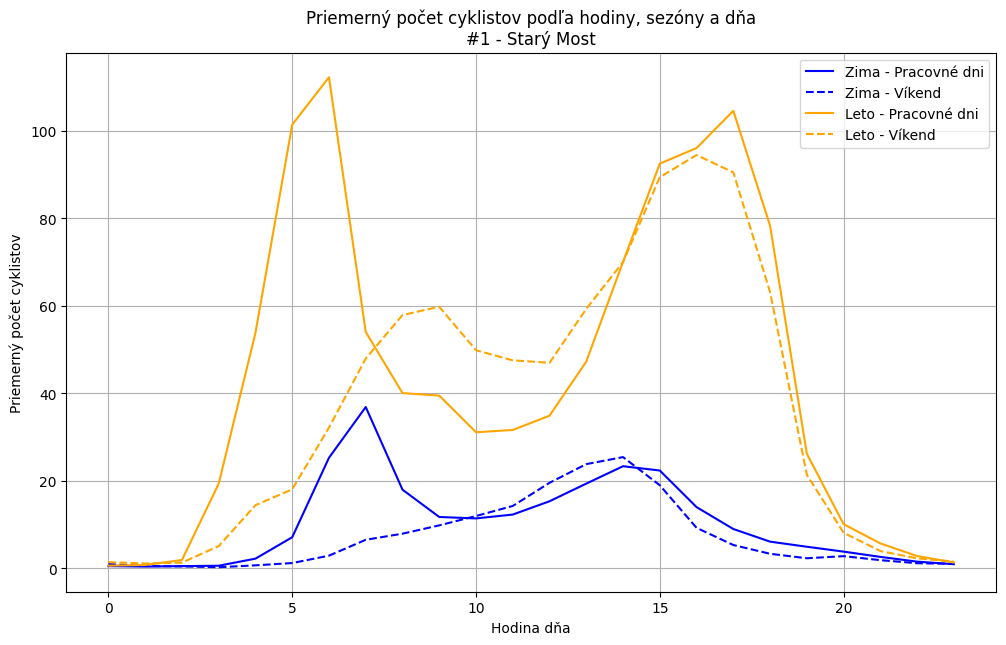

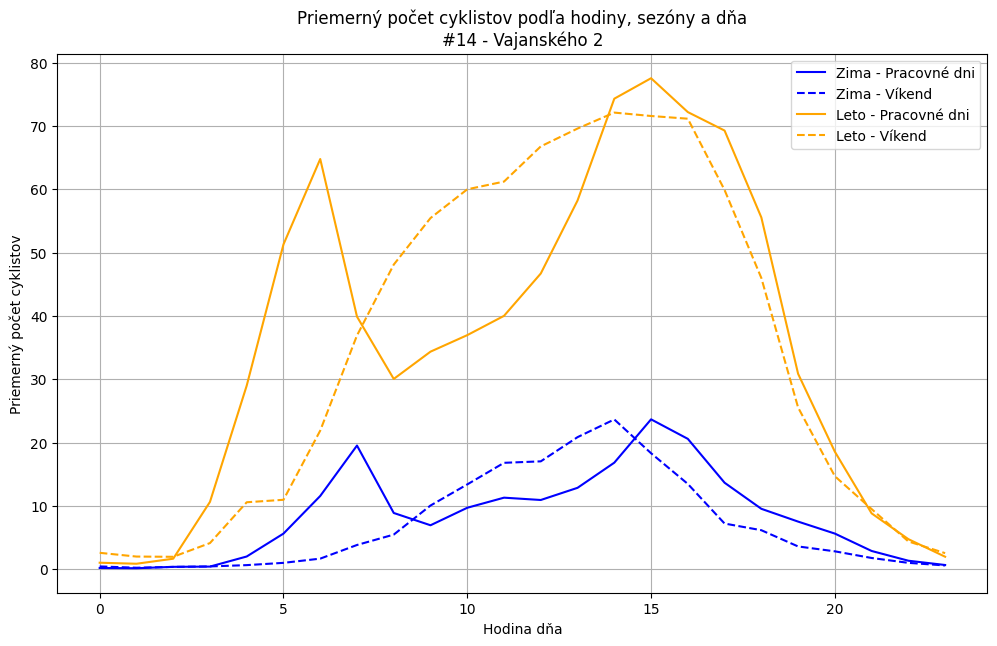

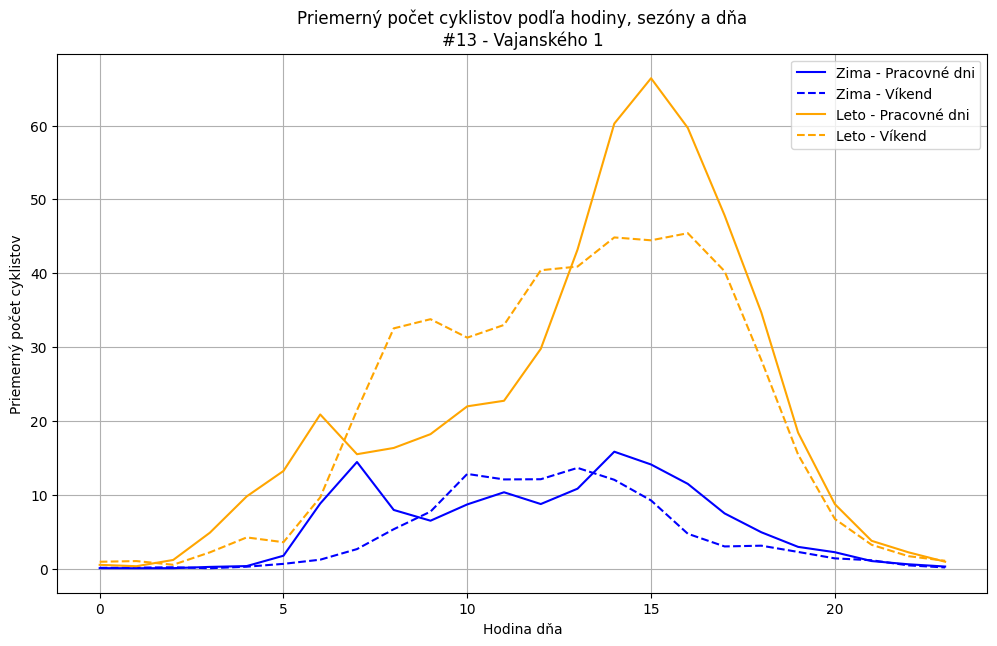

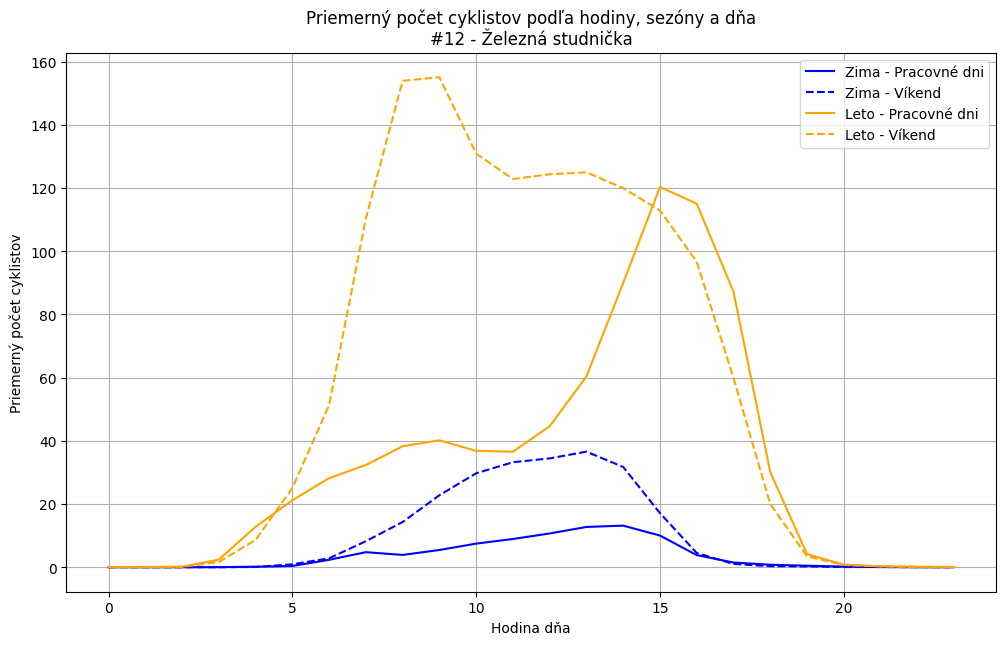

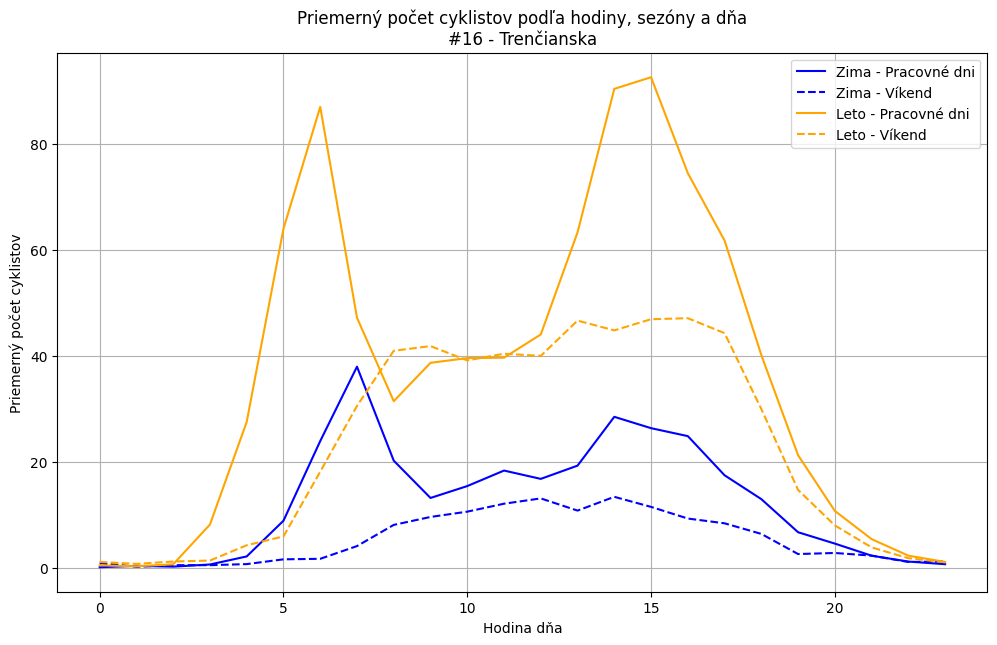

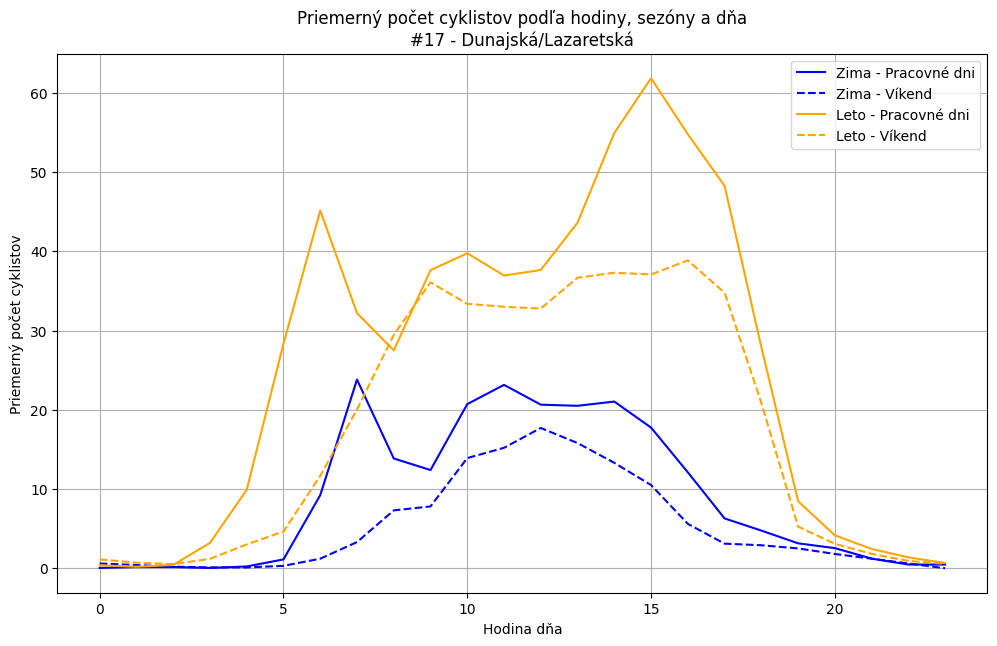

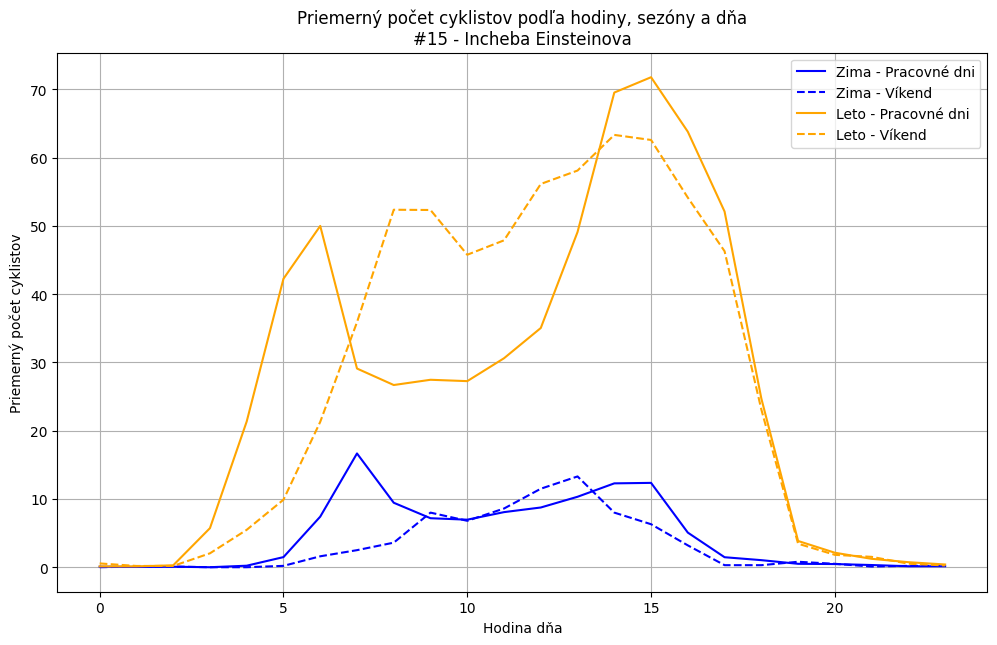

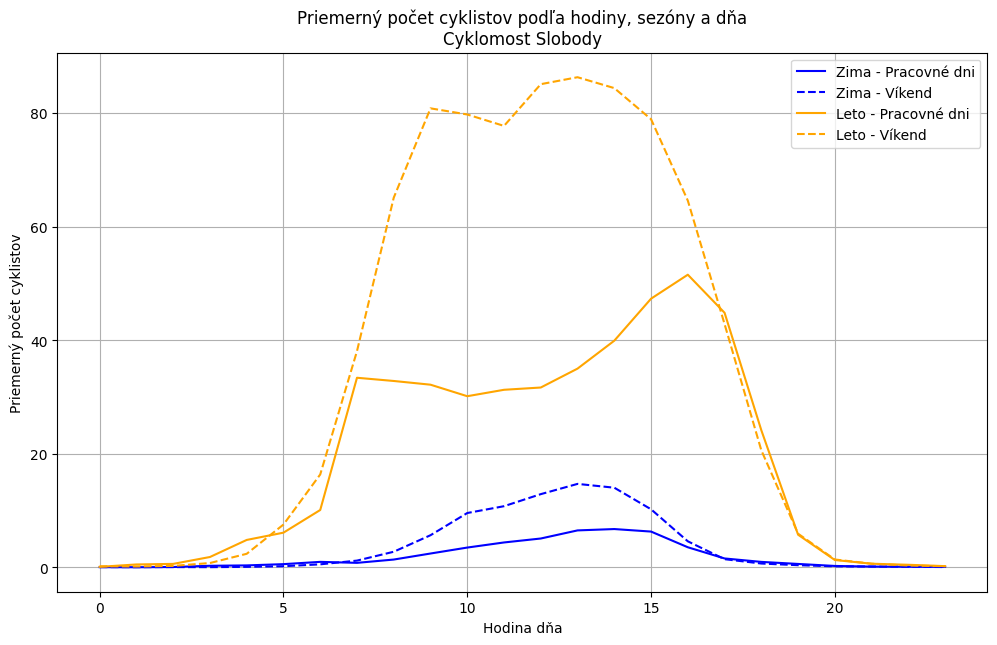

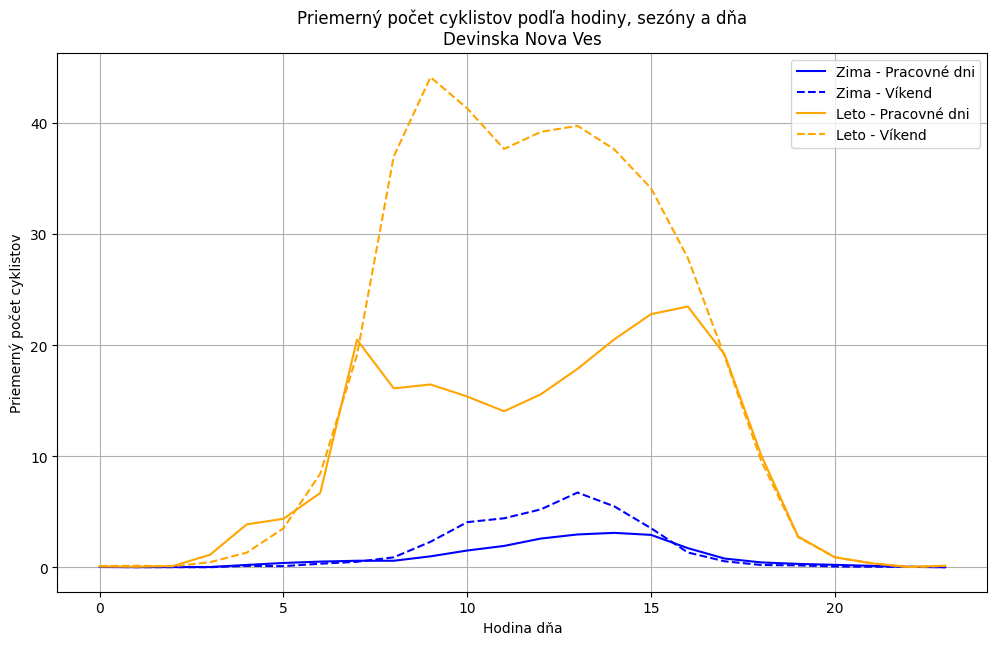

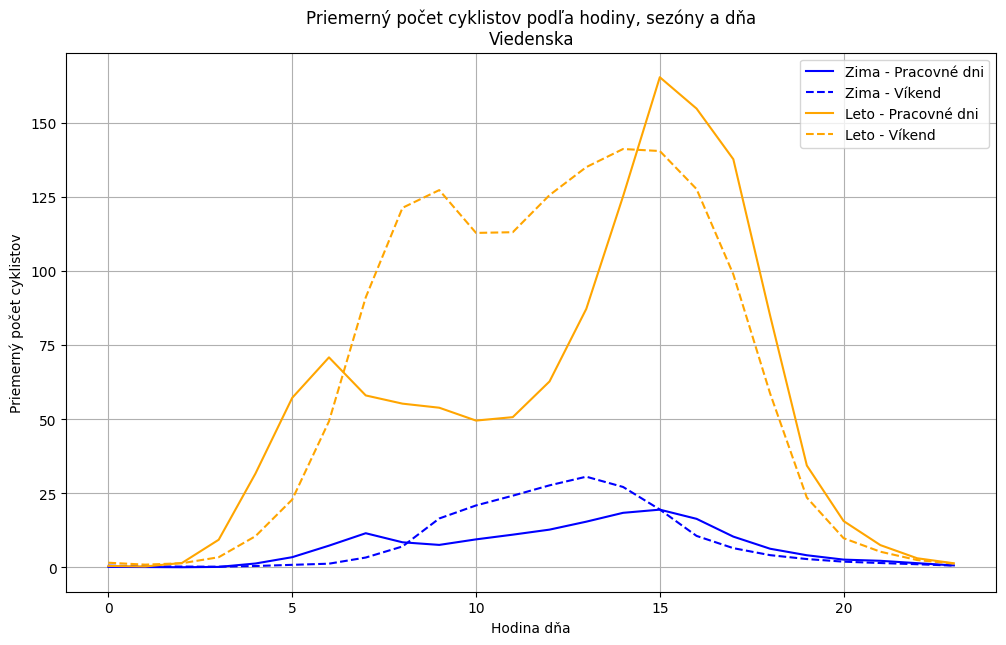

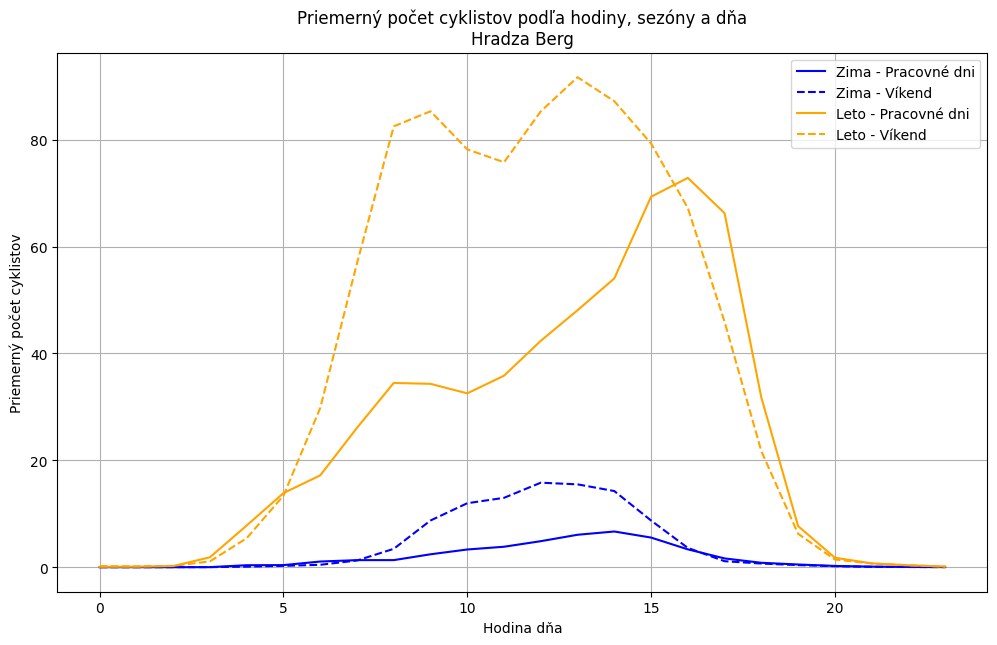

In [25]:
names = data_with_features['name'].unique()

for name in names:
    winter_weekday = (
        data_with_features[(data_with_features['name'] == name) & (data_with_features['is_winter'] == 1) & (data_with_features['is_weekend'] == 0)]
        .groupby("hour")["cyclists_total"]
        .mean()
    )

    winter_weekend = (
        data_with_features[(data_with_features['name'] == name) & (data_with_features['is_winter'] == 1) & (data_with_features['is_weekend'] == 1)]
        .groupby("hour")["cyclists_total"]
        .mean()
    )

    summer_weekday = (
        data_with_features[(data_with_features['name'] == name) & (data_with_features['is_summer'] == 1) & (data_with_features['is_weekend'] == 0)]
        .groupby("hour")["cyclists_total"]
        .mean()
    )

    summer_weekend = (
        data_with_features[(data_with_features['name'] == name) & (data_with_features['is_summer'] == 1) & (data_with_features['is_weekend'] == 1)]
        .groupby("hour")["cyclists_total"]
        .mean()
    )

    plt.figure(figsize=(12, 7))
    plt.plot(winter_weekday.index, winter_weekday.values, label="Zima - Pracovné dni", color="blue", linestyle='-')
    plt.plot(winter_weekend.index, winter_weekend.values, label="Zima - Víkend", color="blue", linestyle='--')

    plt.plot(summer_weekday.index, summer_weekday.values, label="Leto - Pracovné dni", color="orange", linestyle='-')
    plt.plot(summer_weekend.index, summer_weekend.values, label="Leto - Víkend", color="orange", linestyle='--')

    plt.xlabel("Hodina dňa")
    plt.ylabel("Priemerný počet cyklistov")
    plt.title(f"Priemerný počet cyklistov podľa hodiny, sezóny a dňa\n{name}")
    plt.legend()
    plt.grid(True)
    plt.show()


### Winter vs. Summer

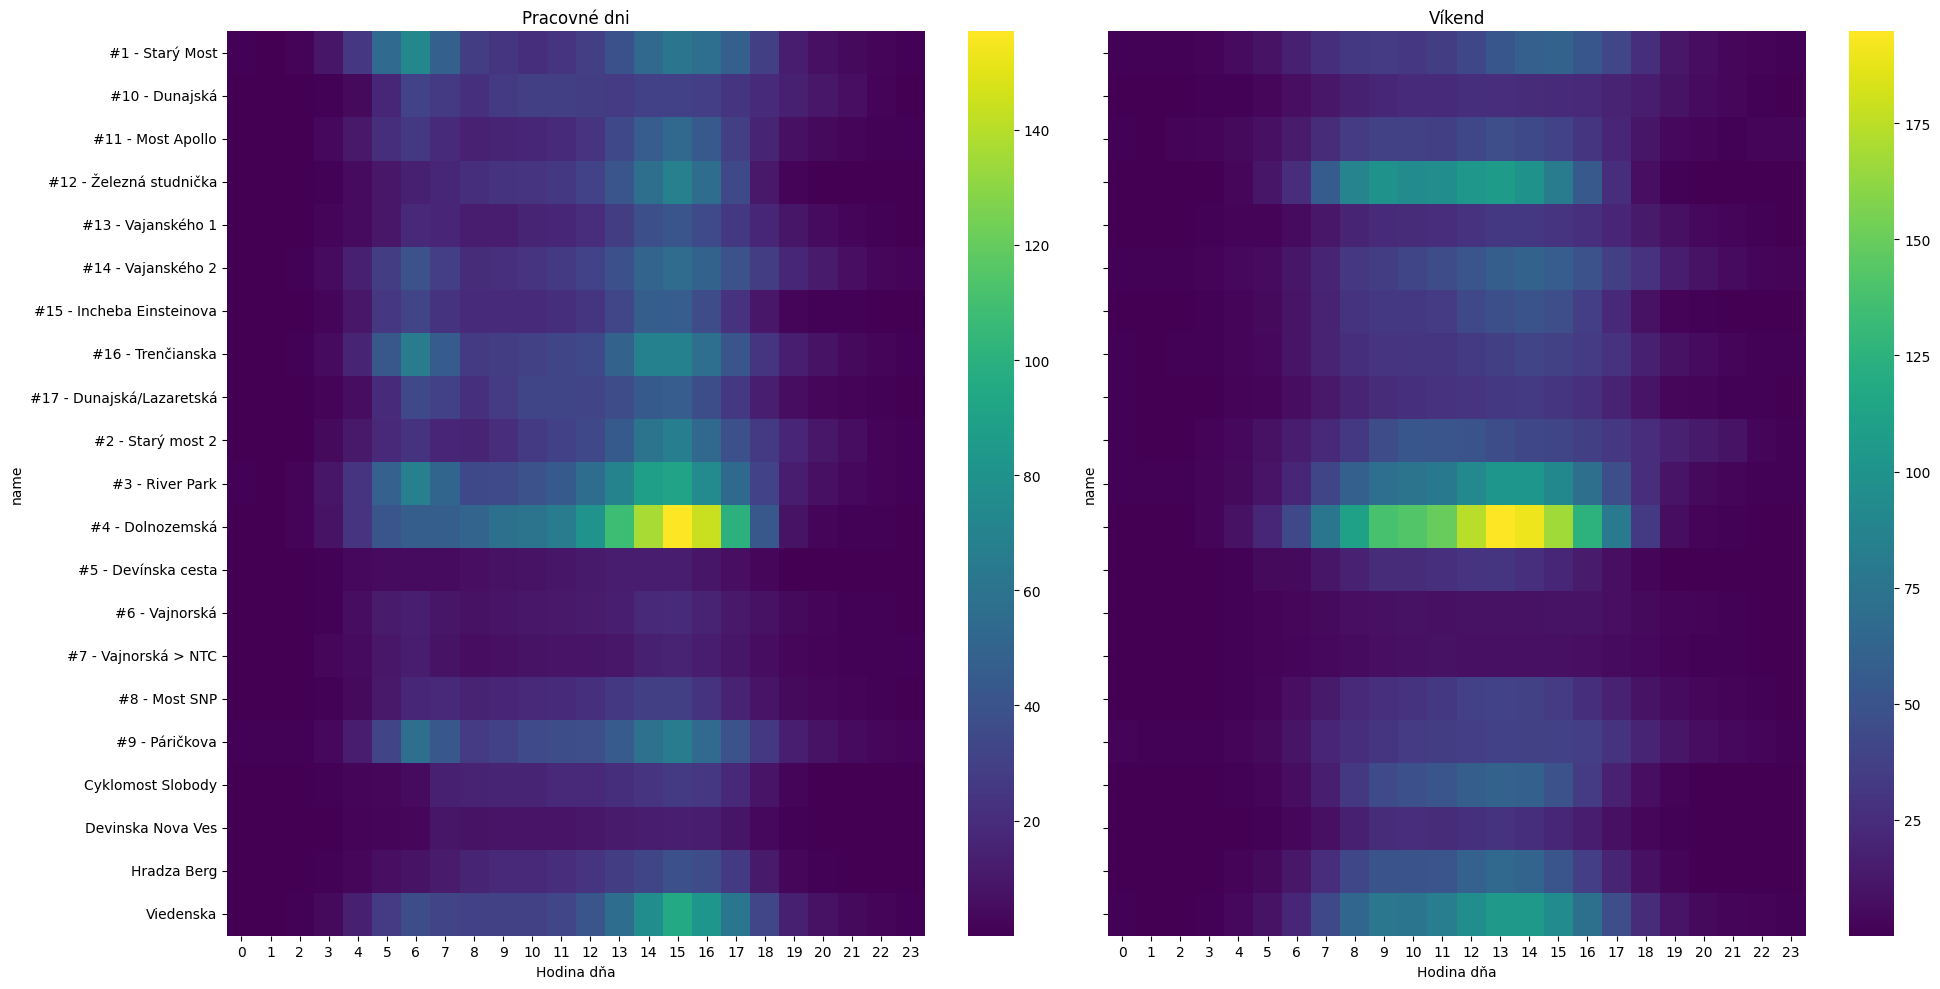

In [20]:
# bit separately for the weekend days and weekdays
pivot_weekday = (
    data_with_features[data_with_features['is_weekend'] == 0]
    .groupby(["name", "hour"])["cyclists_total"]
    .mean()
    .unstack()
)

pivot_weekend = (
    data_with_features[data_with_features['is_weekend'] == 1]
    .groupby(["name", "hour"])["cyclists_total"]
    .mean()
    .unstack()
)

fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
sns.heatmap(pivot_weekday, cmap="viridis", ax=axes[0])
axes[0].set_xlabel("Hodina dňa")
axes[0].set_title("Pracovné dni")

sns.heatmap(pivot_weekend, cmap="viridis", ax=axes[1])
axes[1].set_xlabel("Hodina dňa")
axes[1].set_title("Víkend")

plt.tight_layout()
plt.show()


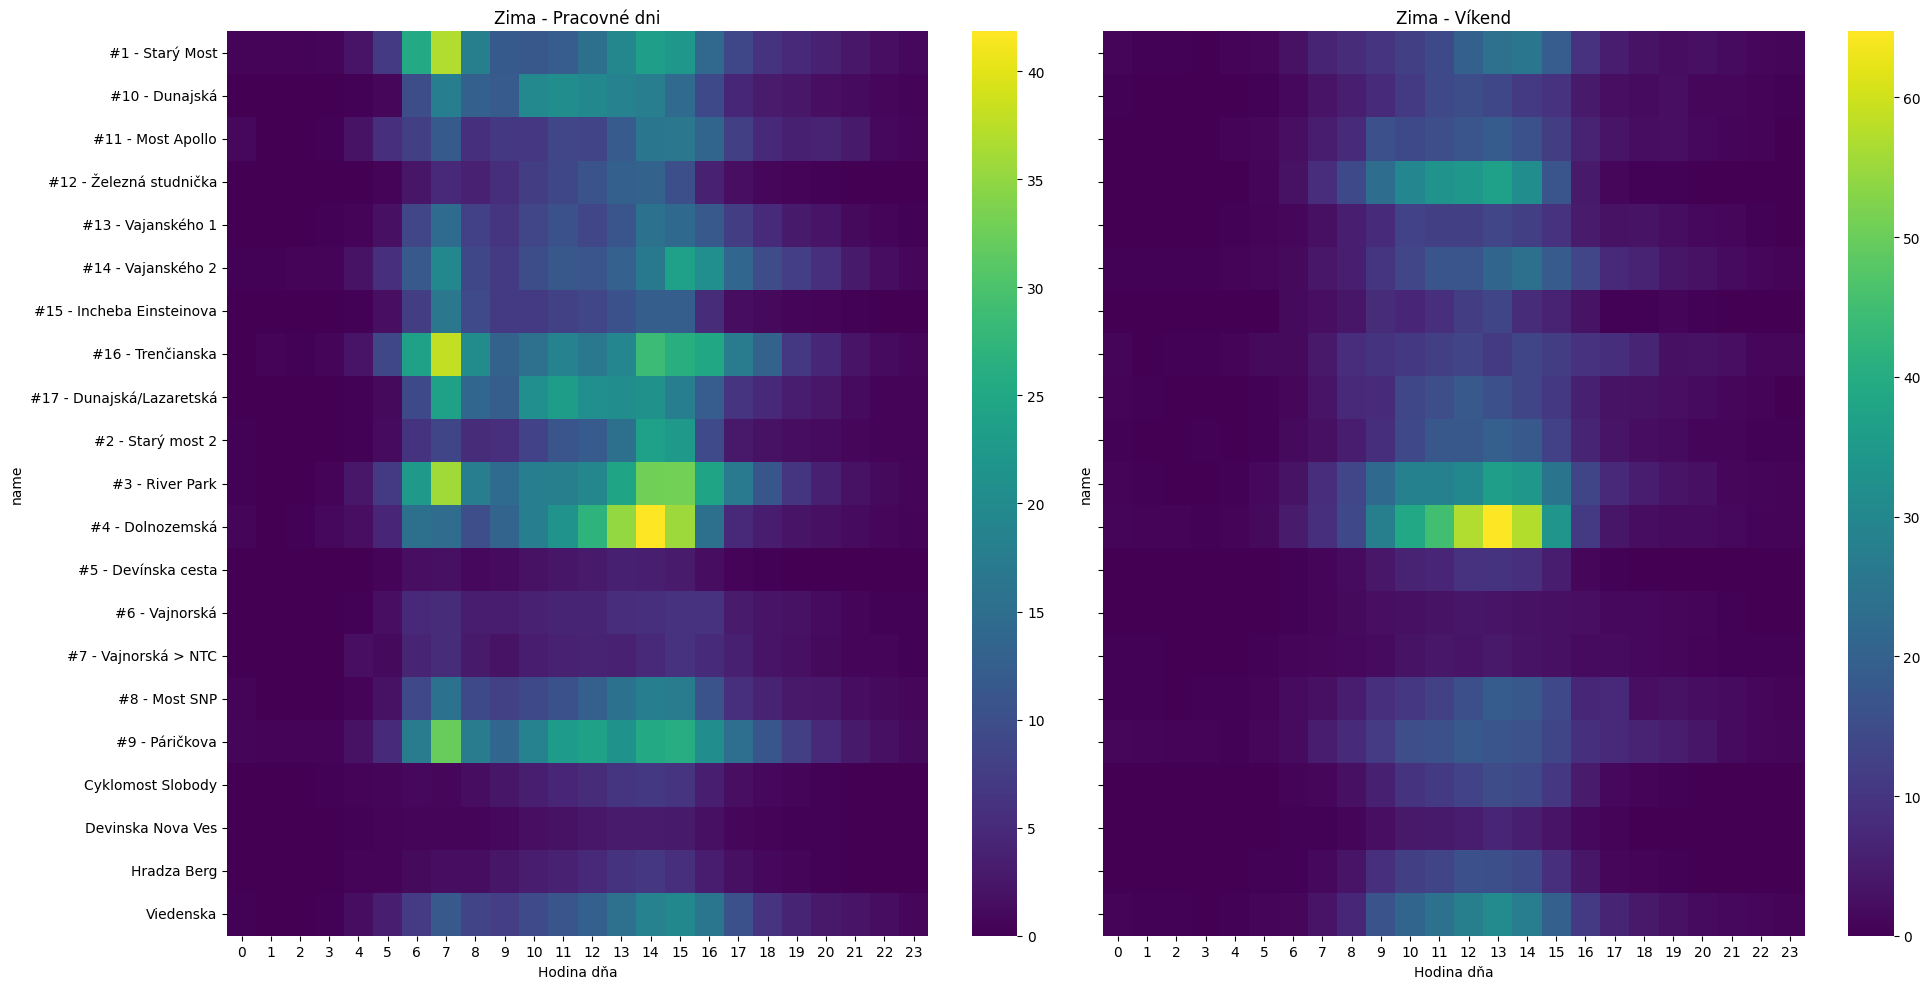

In [34]:
# bit separately for the weekend days and weekdays
pivot_weekday = (
    data_with_features[(data_with_features['is_winter'] == 1) & (data_with_features['is_weekend'] == 0)]
    .groupby(["name", "hour"])["cyclists_total"]
    .mean()
    .unstack()
)

pivot_weekend = (
    data_with_features[(data_with_features['is_winter'] == 1) & (data_with_features['is_weekend'] == 1)]
    .groupby(["name", "hour"])["cyclists_total"]
    .mean()
    .unstack()
)

fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
sns.heatmap(pivot_weekday, cmap="viridis", ax=axes[0])
axes[0].set_xlabel("Hodina dňa")
axes[0].set_title("Zima - Pracovné dni")

sns.heatmap(pivot_weekend, cmap="viridis", ax=axes[1])
axes[1].set_xlabel("Hodina dňa")
axes[1].set_title("Zima - Víkend")

plt.tight_layout()
plt.show()


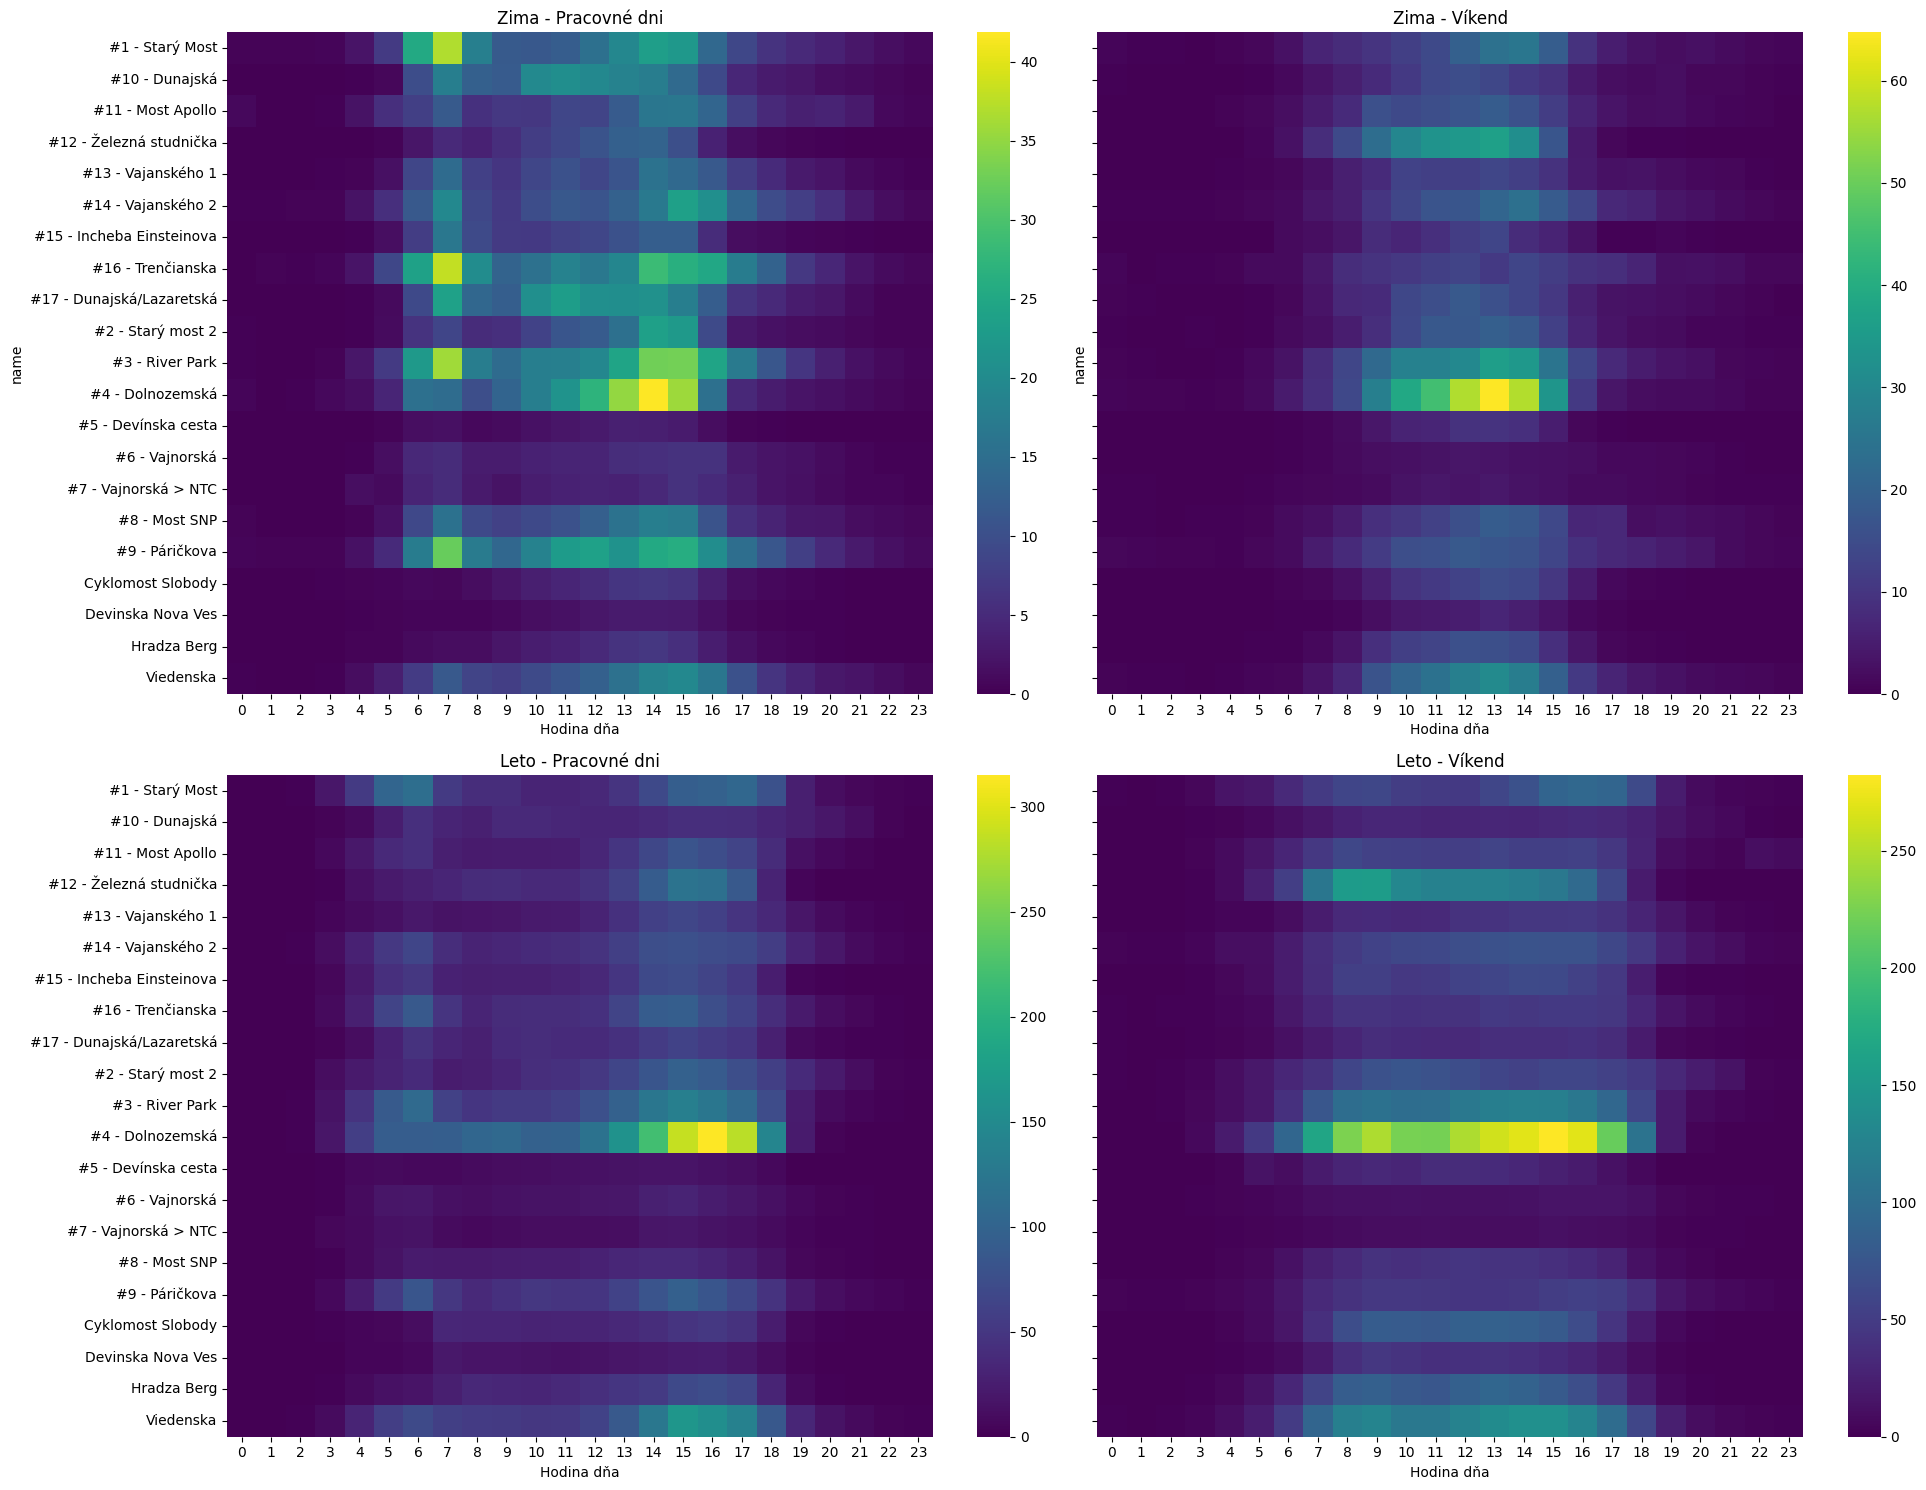

In [22]:
pivot_winter_weekday = (
    data_with_features[(data_with_features['is_winter'] == 1) & (data_with_features['is_weekend'] == 0)]
    .groupby(["name", "hour"])["cyclists_total"]
    .mean()
    .unstack()
)

pivot_winter_weekend = (
    data_with_features[(data_with_features['is_winter'] == 1) & (data_with_features['is_weekend'] == 1)]
    .groupby(["name", "hour"])["cyclists_total"]
    .mean()
    .unstack()
)

pivot_summer_weekday = (
    data_with_features[(data_with_features['is_summer'] == 1) & (data_with_features['is_weekend'] == 0)]
    .groupby(["name", "hour"])["cyclists_total"]
    .mean()
    .unstack()
)

pivot_summer_weekend = (
    data_with_features[(data_with_features['is_summer'] == 1) & (data_with_features['is_weekend'] == 1)]
    .groupby(["name", "hour"])["cyclists_total"]
    .mean()
    .unstack()
)

fig, axes = plt.subplots(2, 2, figsize=(20, 15), sharey=True)

sns.heatmap(pivot_winter_weekday, cmap="viridis", ax=axes[0, 0])
axes[0, 0].set_title("Zima - Pracovné dni")
axes[0, 0].set_xlabel("Hodina dňa")

sns.heatmap(pivot_winter_weekend, cmap="viridis", ax=axes[0, 1])
axes[0, 1].set_title("Zima - Víkend")
axes[0, 1].set_xlabel("Hodina dňa")

sns.heatmap(pivot_summer_weekday, cmap="viridis", ax=axes[1, 0])
axes[1, 0].set_title("Leto - Pracovné dni")
axes[1, 0].set_xlabel("Hodina dňa")
axes[1, 0].set_ylabel("")

sns.heatmap(pivot_summer_weekend, cmap="viridis", ax=axes[1, 1])
axes[1, 1].set_title("Leto - Víkend")
axes[1, 1].set_xlabel("Hodina dňa")
axes[1, 1].set_ylabel("")

plt.tight_layout()
plt.show()



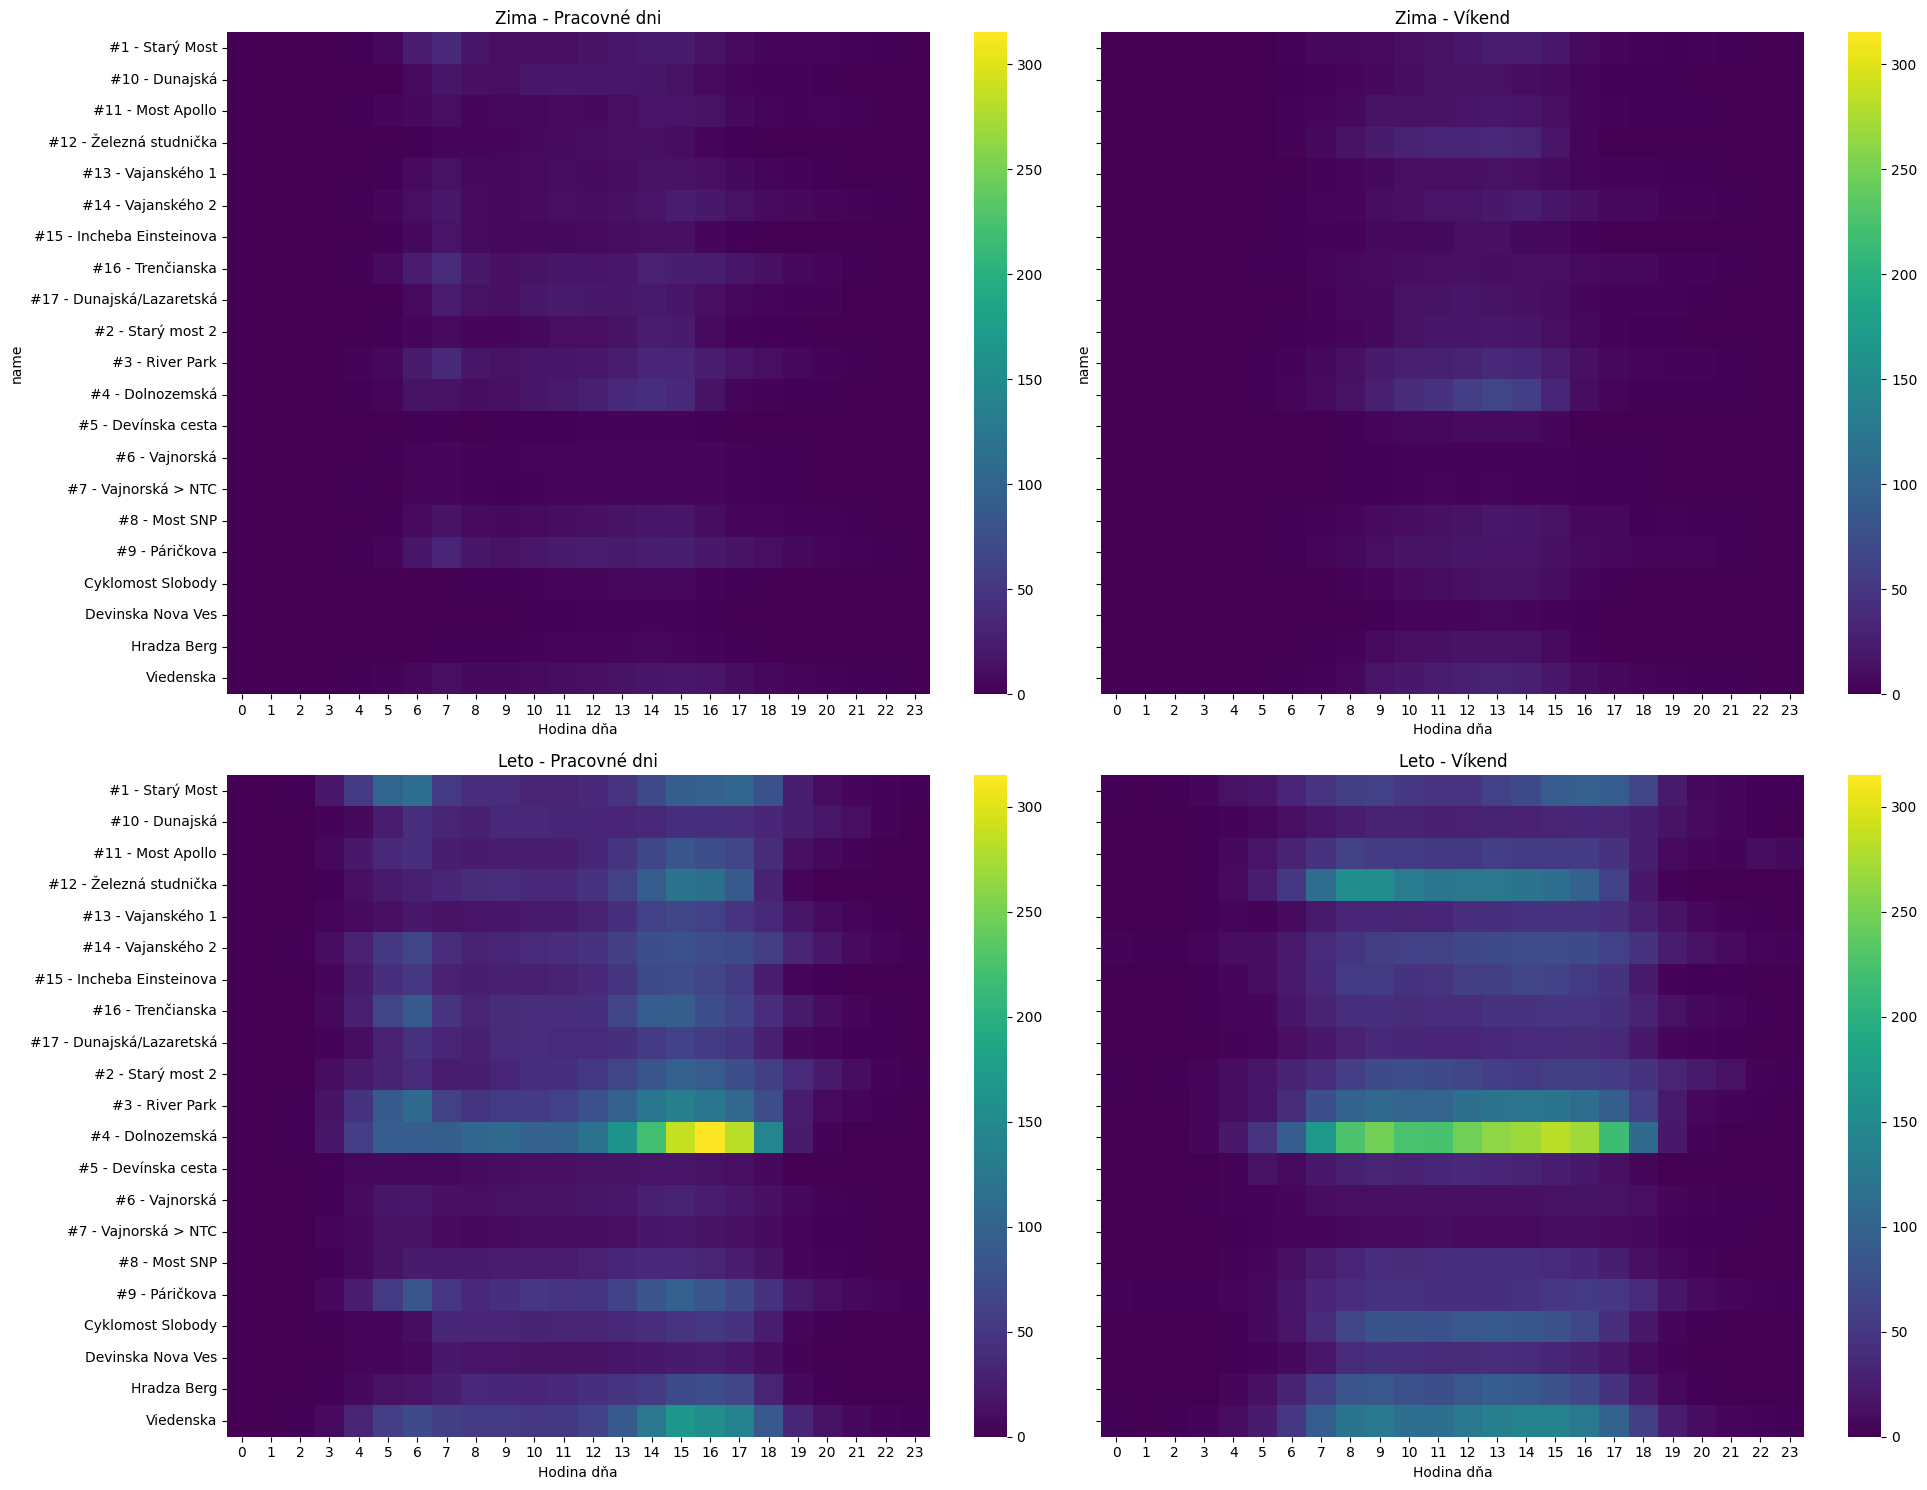

In [35]:
global_max = max(
    pivot_winter_weekday.max().max(),
    pivot_winter_weekend.max().max(),
    pivot_summer_weekday.max().max(),
    pivot_summer_weekend.max().max()
)

fig, axes = plt.subplots(2, 2, figsize=(20, 15), sharey=True)

# Nastavenie vmin a vmax zabezpečí rovnakú farebnú škálu
heatmap_kwargs = dict(cmap="viridis", vmin=0, vmax=global_max)

sns.heatmap(pivot_winter_weekday, ax=axes[0, 0], **heatmap_kwargs)
axes[0, 0].set_title("Zima - Pracovné dni")
axes[0, 0].set_xlabel("Hodina dňa")

sns.heatmap(pivot_winter_weekend, ax=axes[0, 1], **heatmap_kwargs)
axes[0, 1].set_title("Zima - Víkend")
axes[0, 1].set_xlabel("Hodina dňa")

sns.heatmap(pivot_summer_weekday, ax=axes[1, 0], **heatmap_kwargs)
axes[1, 0].set_title("Leto - Pracovné dni")
axes[1, 0].set_xlabel("Hodina dňa")
axes[1, 0].set_ylabel("")

sns.heatmap(pivot_summer_weekend, ax=axes[1, 1], **heatmap_kwargs)
axes[1, 1].set_title("Leto - Víkend")
axes[1, 1].set_xlabel("Hodina dňa")
axes[1, 1].set_ylabel("")

plt.tight_layout()
plt.show()

### Seasonality - By Month

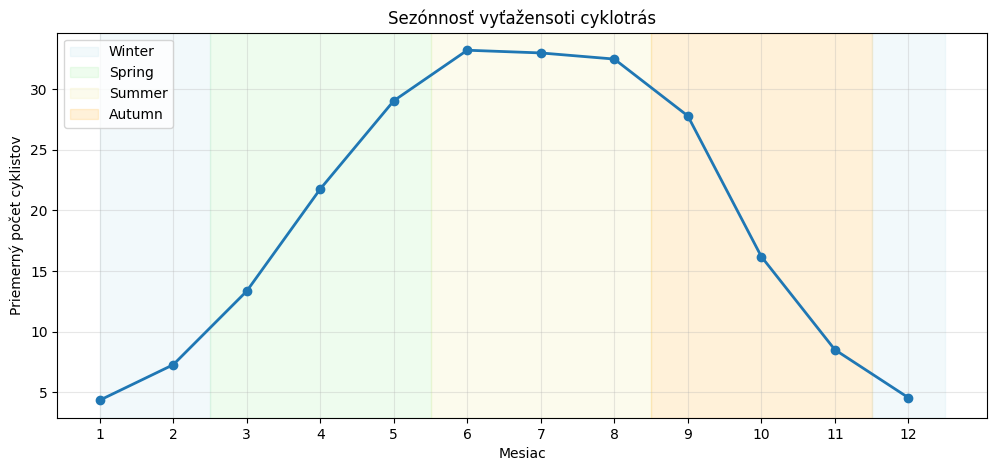

In [41]:
plt.figure(figsize=(12, 5))
avg_by_month = (
    data_with_features
    .groupby("month")["cyclists_total"]
    .mean()
)
# main line
plt.plot(
    avg_by_month.index,
    avg_by_month.values,
    marker="o",
    linewidth=2
)

# coloring based on seasons
plt.axvspan(1, 2.5, alpha=0.15, color="lightblue", label="Winter")
plt.axvspan(2.5, 5.5, alpha=0.15, color="lightgreen", label="Spring")
plt.axvspan(5.5, 8.5, alpha=0.15, color="khaki", label="Summer")
plt.axvspan(8.5, 11.5, alpha=0.15, color="orange", label="Autumn")
plt.axvspan(11.5, 12.5, alpha=0.15, color="lightblue")

plt.xlabel("Mesiac")
plt.ylabel("Priemerný počet cyklistov")
plt.title("Sezónnosť vyťažensoti cyklotrás")
plt.xticks(range(1, 13))
plt.legend(loc="upper left")
plt.grid(alpha=0.3)
plt.show()


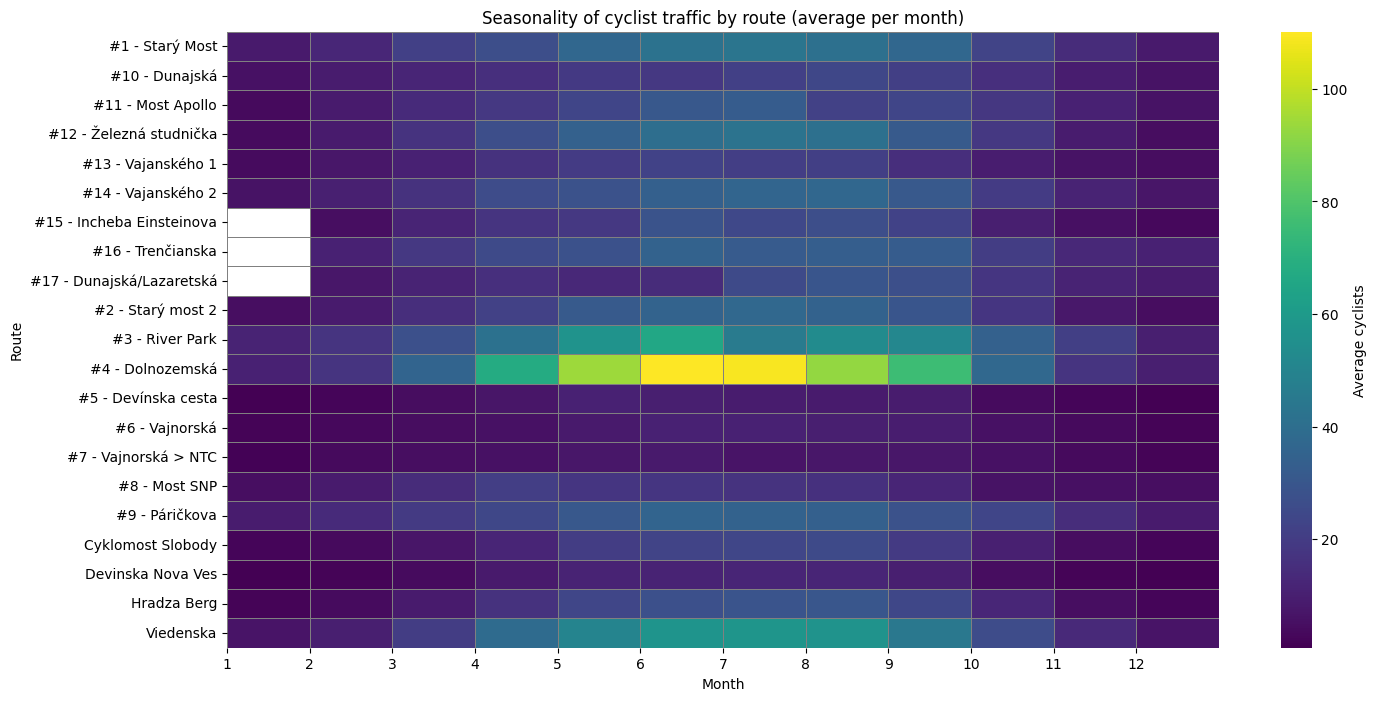

In [38]:
# musime brat do uvahy kolko rokov boli pridavane data pre jednotlive trasy?
pivot_month = (
    data_with_features
    .groupby(["name", "month"])["cyclists_total"]
    .mean()
    .unstack()
)

plt.figure(figsize=(16, 8))
sns.heatmap(pivot_month, cmap="viridis", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Average cyclists'})
plt.xlabel("Month")
plt.ylabel("Route")
plt.title("Seasonality of cyclist traffic by route (average per month)")
plt.xticks(ticks=range(0,12), labels=range(1,13))
plt.show()

C:\Users\Uzivatel\AppData\Local\Temp\ipykernel_34052\1305923810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


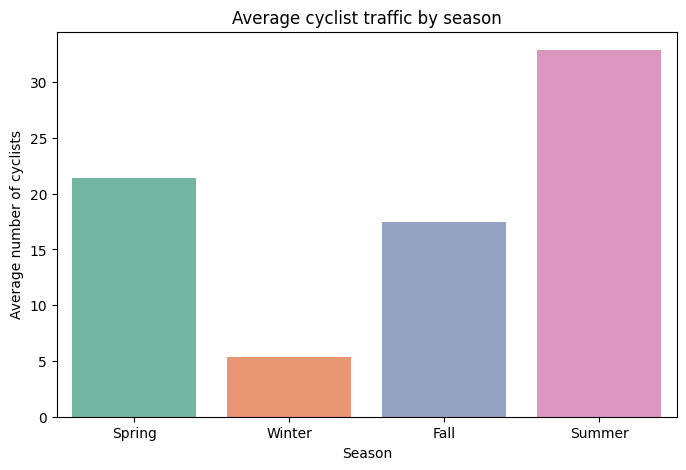

In [36]:
data_season = data_with_features.copy()

data_season["season"] = (
    data_season["is_spring"].map({1: "Spring", 0: None})
    .fillna(data_season["is_summer"].map({1: "Summer", 0: None}))
    .fillna(data_season["is_fall"].map({1: "Fall", 0: None}))
    .fillna(data_season["is_winter"].map({1: "Winter", 0: None}))
)
plt.figure(figsize=(8, 5))

sns.barplot(
    data=data_season,
    x="season",
    y="cyclists_total",
    estimator="mean",
    errorbar=None,
    palette="Set2"
)

plt.xlabel("Season")
plt.ylabel("Average number of cyclists")
plt.title("Average cyclist traffic by season")
plt.show()

C:\Users\Uzivatel\AppData\Local\Temp\ipykernel_34052\2970090152.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


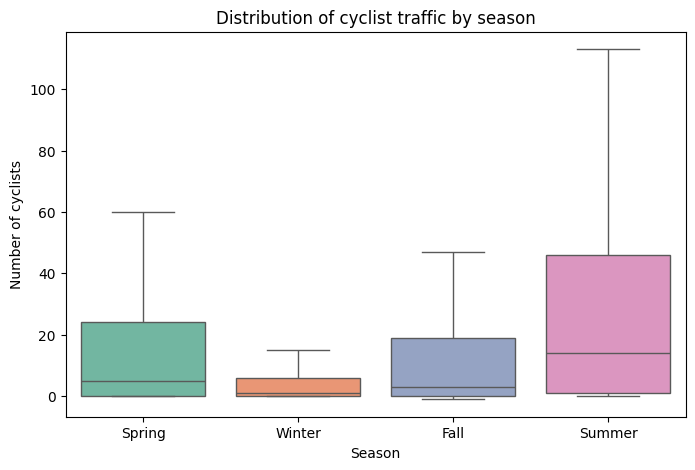

In [37]:
plt.figure(figsize=(8, 5))

sns.boxplot(
    data=data_season,
    x="season",
    y="cyclists_total",
    palette="Set2",
    showfliers=False
)

plt.xlabel("Season")
plt.ylabel("Number of cyclists")
plt.title("Distribution of cyclist traffic by season")
plt.show()

Koeficient variability

In [ ]:
# vyssia hodnota - vyssia sezonan variabiita    
seasonal_stats = (
    data_with_features
    .groupby(["name", "month"])["cyclists_total"]
    .mean()
    .unstack()  # trasy ako riadky, mesiace ako stĺpce
)

# Vypočítaj CV pre každý riadok (trasu)
cv = seasonal_stats.std(axis=1) / seasonal_stats.mean(axis=1)

# Výsledok do DataFrame pre prehľadnosť
cv_df = cv.reset_index()
cv_df.columns = ["name", "CV"]

print(cv_df.sort_values("CV", ascending=False))

                         name        CV
18          Devinska Nova Ves  0.722079
19                Hradza Berg  0.721445
17          Cyklomost Slobody  0.713926
11           #4 - Dolnozemská  0.695054
12        #5 - Devínska cesta  0.654714
20                  Viedenska  0.643972
3     #12 - Železná studnička  0.635981
9           #2 - Starý most 2  0.610821
6   #15 - Incheba Einsteinova  0.586570
13             #6 - Vajnorská  0.552523
4          #13 - Vajanského 1  0.527761
2           #11 - Most Apollo  0.525573
5          #14 - Vajanského 2  0.525336
10            #3 - River Park  0.521216
0             #1 - Starý Most  0.516155
15              #8 - Most SNP  0.478086
8   #17 - Dunajská/Lazaretská  0.463691
14       #7 - Vajnorská > NTC  0.435177
16             #9 - Páričkova  0.426659
1              #10 - Dunajská  0.424096
7           #16 - Trenčianska  0.391287


Leto vs zima

In [ ]:
# Priemerný počet cyklistov v lete (mesiace 6,7,8)
summer_avg = seasonal_stats[[6,7,8]].mean(axis=1)

# Priemerný počet cyklistov v zime (mesiace 12,1,2)
# Pozor na index 12 a 1,2, ktoré sú mimo zoradenia, preto spravíme takto:
winter_avg = seasonal_stats[[12,1,2]].mean(axis=1)

# Pomery leto/zima
ratio = summer_avg / winter_avg

ratio_df = ratio.reset_index()
ratio_df.columns = ["name", "Summer/Winter ratio"]

print(ratio_df.sort_values("Summer/Winter ratio", ascending=False))


                         name  Summer/Winter ratio
19                Hradza Berg            11.270605
18          Devinska Nova Ves            10.615777
17          Cyklomost Slobody             9.599556
11           #4 - Dolnozemská             8.109637
20                  Viedenska             7.481155
3     #12 - Železná studnička             7.340202
12        #5 - Devínska cesta             7.134531
6   #15 - Incheba Einsteinova             6.543705
9           #2 - Starý most 2             6.050375
13             #6 - Vajnorská             4.654494
2           #11 - Most Apollo             4.585361
5          #14 - Vajanského 2             4.553052
0             #1 - Starý Most             4.353474
10            #3 - River Park             4.307748
4          #13 - Vajanského 1             4.090471
14       #7 - Vajnorská > NTC             3.327418
16             #9 - Páričkova             3.268692
1              #10 - Dunajská             3.083018
7           #16 - Trenčianska  

### Data

In [ ]:
year_range = (
    data_with_features
    .groupby("name")["year"]
    .agg(["min", "max"])
    .reset_index()
)

year_range.columns = ["name", "start_year", "end_year"]

print(year_range)


                         name  start_year  end_year
0             #1 - Starý Most        2022      2025
1              #10 - Dunajská        2023      2025
2           #11 - Most Apollo        2023      2025
3     #12 - Železná studnička        2023      2025
4          #13 - Vajanského 1        2024      2025
5          #14 - Vajanského 2        2024      2025
6   #15 - Incheba Einsteinova        2025      2025
7           #16 - Trenčianska        2025      2025
8   #17 - Dunajská/Lazaretská        2025      2025
9           #2 - Starý most 2        2023      2025
10            #3 - River Park        2022      2025
11           #4 - Dolnozemská        2022      2025
12        #5 - Devínska cesta        2023      2025
13             #6 - Vajnorská        2023      2025
14       #7 - Vajnorská > NTC        2023      2025
15              #8 - Most SNP        2023      2025
16             #9 - Páričkova        2023      2025
17          Cyklomost Slobody        2014      2025
18          

In [ ]:
# TODO: koronove roky

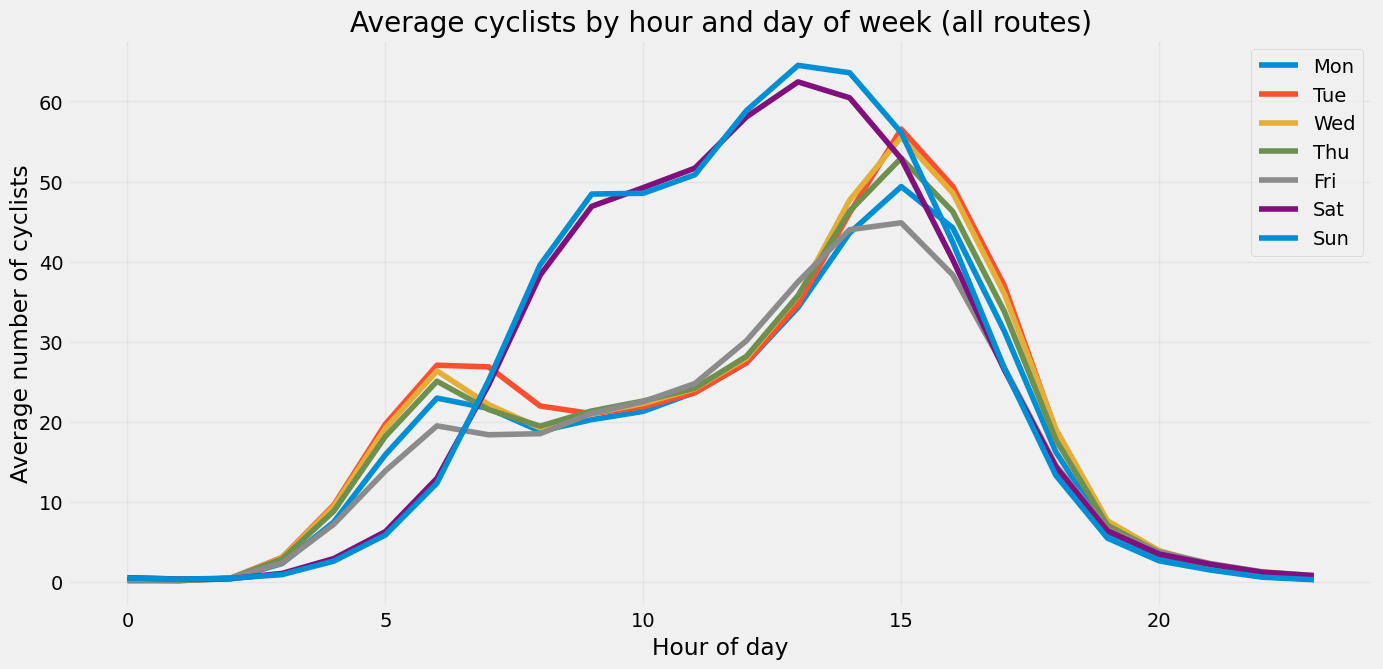

In [ ]:
avg_by_hour_day = (
    data_with_features
    .groupby(["dayofweek", "hour"])["cyclists_total"]
    .mean()
    .unstack(level=0)  # premení dni v týždni na stĺpce
)

plt.figure(figsize=(15, 7))
for day in range(7):
    plt.plot(
        avg_by_hour_day.index,
        avg_by_hour_day[day],
        label=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"][day]
    )

plt.xlabel("Hour of day")
plt.ylabel("Average number of cyclists")
plt.title("Average cyclists by hour and day of week (all routes)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


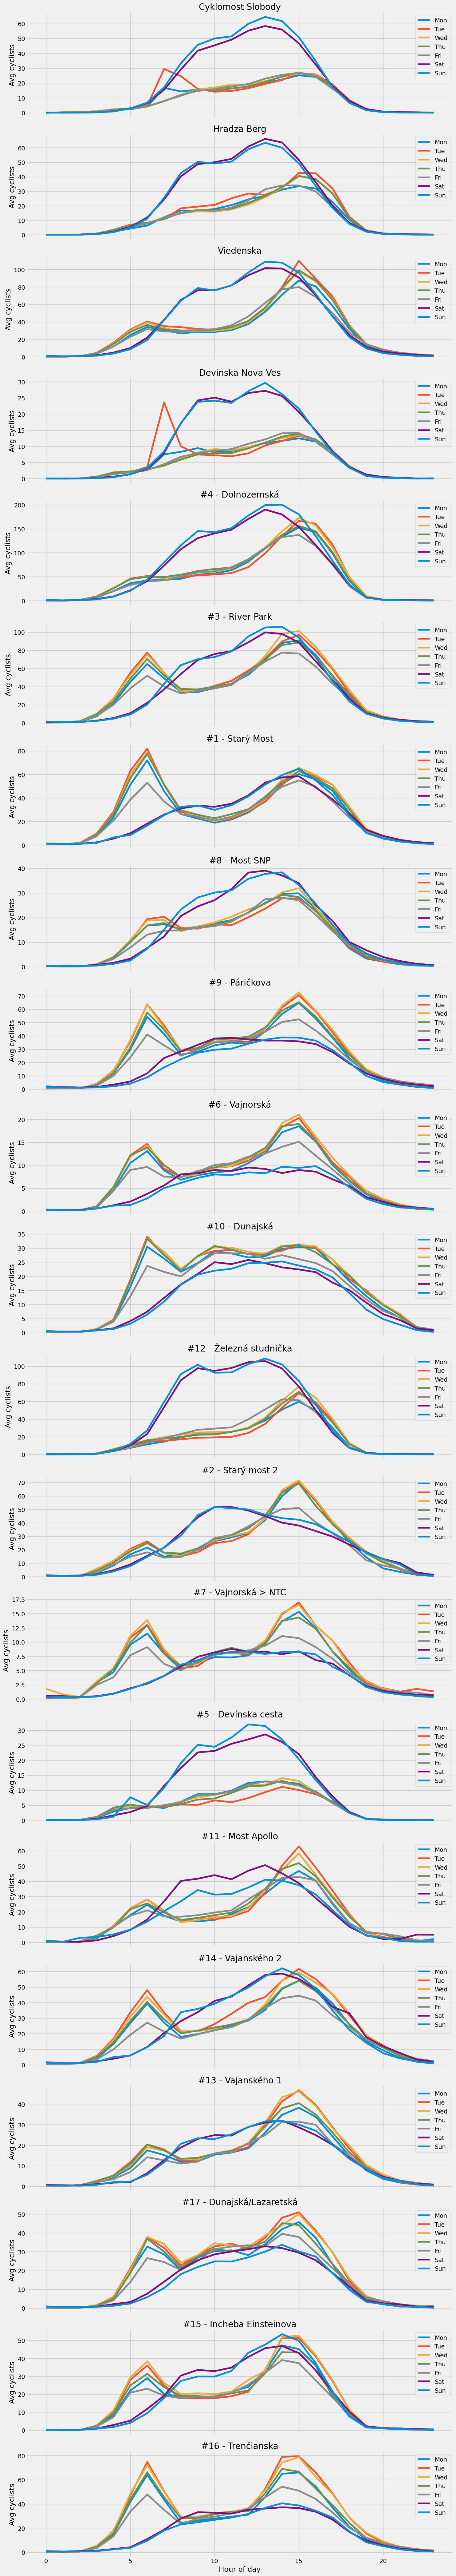

In [ ]:
# Vyber pár trás na vizualizáciu
routes_to_plot = data_with_features["name"].value_counts().index[:]

fig, axes = plt.subplots(len(routes_to_plot), 1, figsize=(15, 4 * len(routes_to_plot)), sharex=True)

days_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

for ax, route in zip(axes, routes_to_plot):
    subset = data_with_features[data_with_features["name"] == route]
    avg = (
        subset
        .groupby(["dayofweek", "hour"])["cyclists_total"]
        .mean()
        .unstack(level=0)  # dni v týždni ako stĺpce
    )
    for day in range(7):
        ax.plot(avg.index, avg[day], label=days_labels[day])
    ax.set_title(route)
    ax.set_ylabel("Avg cyclists")
    ax.legend(loc="upper right")

axes[-1].set_xlabel("Hour of day")
plt.tight_layout()
plt.show()

### Based on Directions

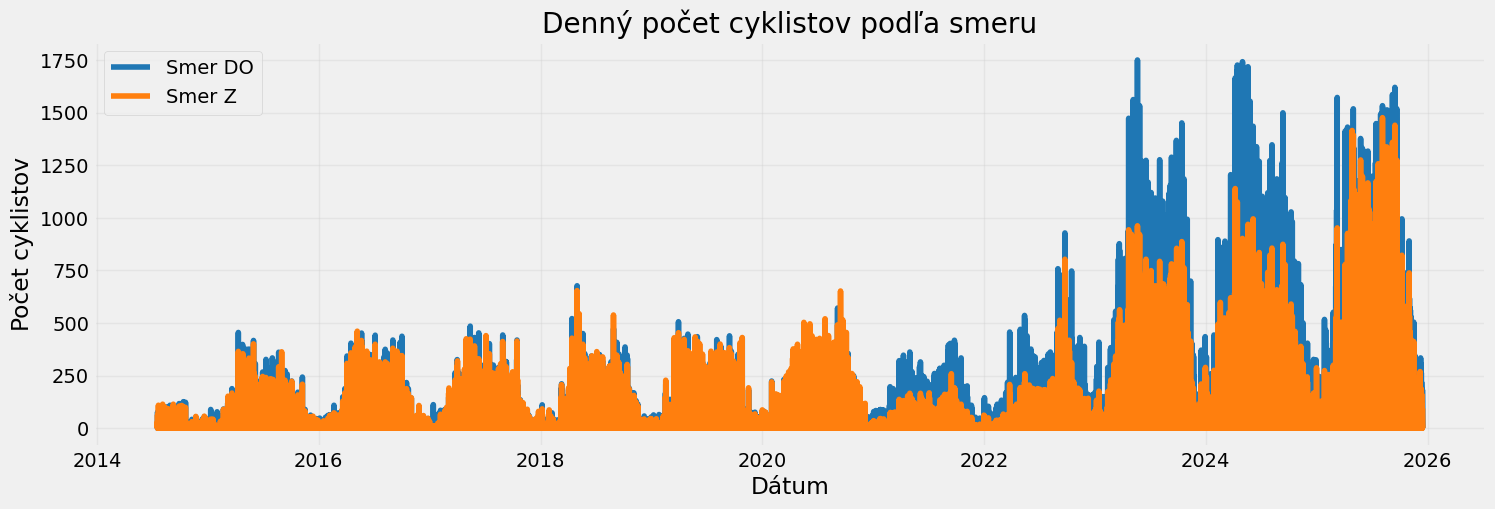

In [ ]:
daily_counts = data_with_features.groupby("date_time")[["direction_to", "direction_from"]].sum()

plt.figure(figsize=(16,5))
plt.plot(daily_counts.index, daily_counts["direction_to"], label="Smer DO", color="tab:blue")
plt.plot(daily_counts.index, daily_counts["direction_from"], label="Smer Z", color="tab:orange")
plt.xlabel("Dátum")
plt.ylabel("Počet cyklistov")
plt.title("Denný počet cyklistov podľa smeru")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

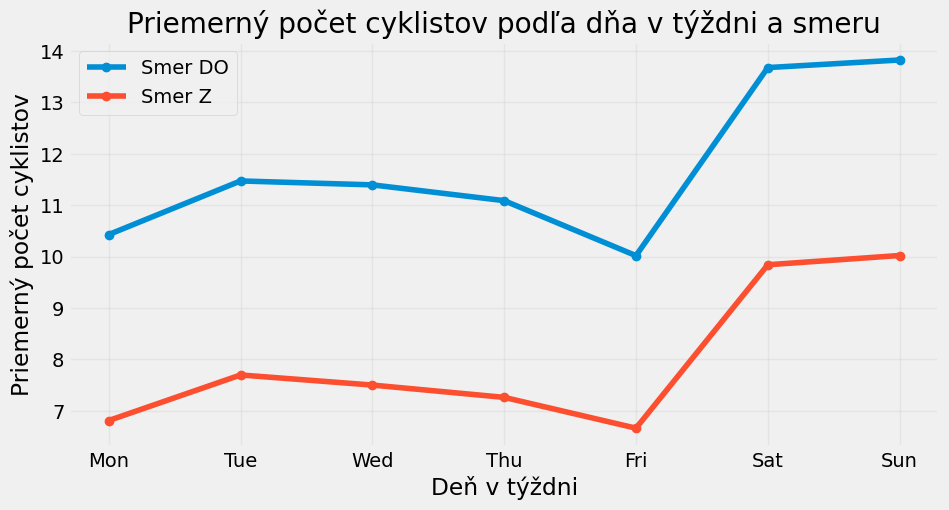

In [ ]:
avg_by_day = (
    data_with_features
    .groupby("dayofweek")[["direction_to", "direction_from"]]
    .mean()
)

days_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

plt.figure(figsize=(10,5))
plt.plot(days_labels, avg_by_day["direction_to"], marker="o", label="Smer DO")
plt.plot(days_labels, avg_by_day["direction_from"], marker="o", label="Smer Z")
plt.xlabel("Deň v týždni")
plt.ylabel("Priemerný počet cyklistov")
plt.title("Priemerný počet cyklistov podľa dňa v týždni a smeru")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


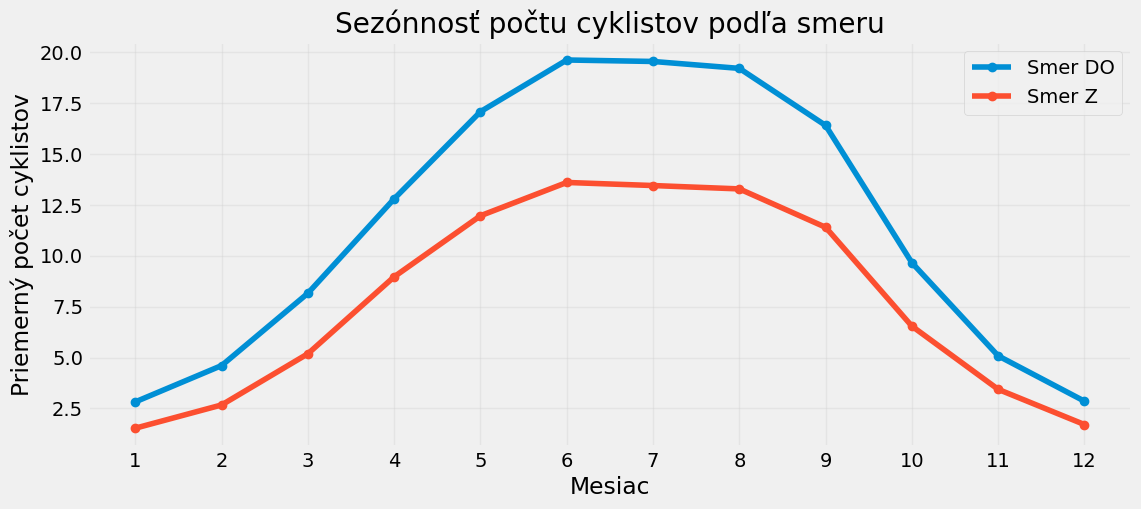

In [ ]:
avg_by_month = (
    data_with_features
    .groupby("month")[["direction_to", "direction_from"]]
    .mean()
)

plt.figure(figsize=(12,5))
plt.plot(avg_by_month.index, avg_by_month["direction_to"], marker="o", label="Smer DO")
plt.plot(avg_by_month.index, avg_by_month["direction_from"], marker="o", label="Smer Z")
plt.xlabel("Mesiac")
plt.ylabel("Priemerný počet cyklistov")
plt.title("Sezónnosť počtu cyklistov podľa smeru")
plt.xticks(range(1,13))
plt.legend()
plt.grid(alpha=0.3)
plt.show()


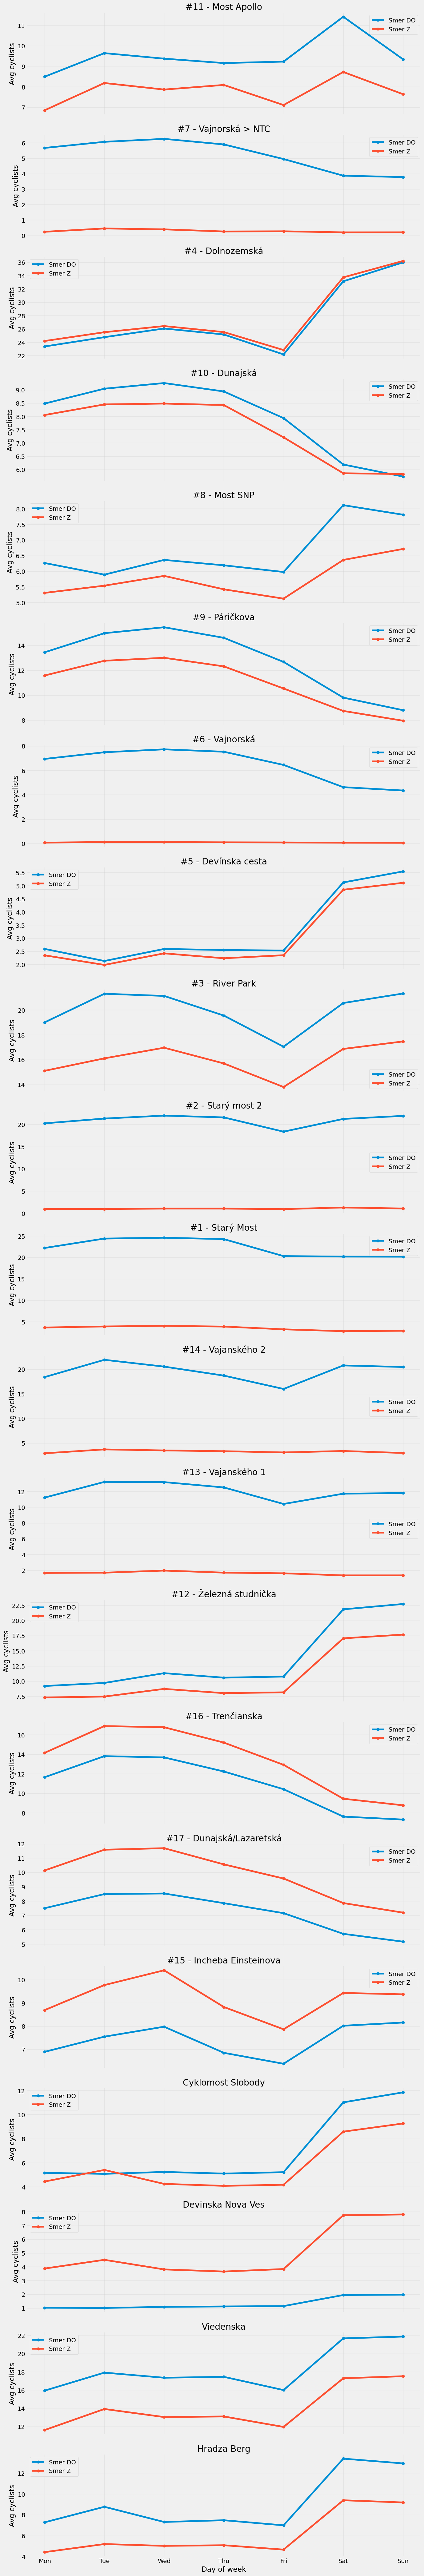

In [ ]:
routes = data_with_features["name"].unique()
days_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

fig, axes = plt.subplots(len(routes), 1, figsize=(14, 4 * len(routes)), sharex=True)

if len(routes) == 1:
    axes = [axes]

for ax, route in zip(axes, routes):
    subset = data_with_features[data_with_features["name"] == route]

    avg = (
        subset
        .groupby("dayofweek")[["direction_to", "direction_from"]]
        .mean()
    )

    ax.plot(days_labels, avg["direction_to"], marker="o", label="Smer DO")
    ax.plot(days_labels, avg["direction_from"], marker="o", label="Smer Z")

    ax.set_title(route)
    ax.set_ylabel("Avg cyclists")
    ax.legend()
    ax.grid(alpha=0.3)

axes[-1].set_xlabel("Day of week")
plt.tight_layout()
plt.show()

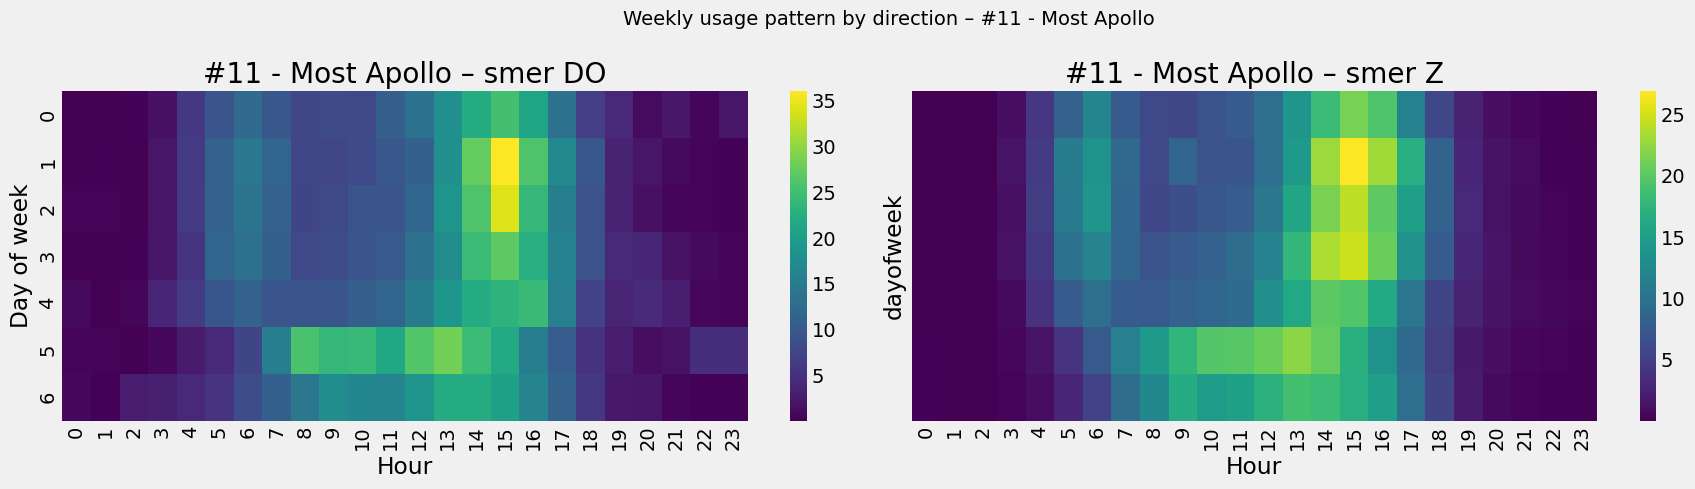

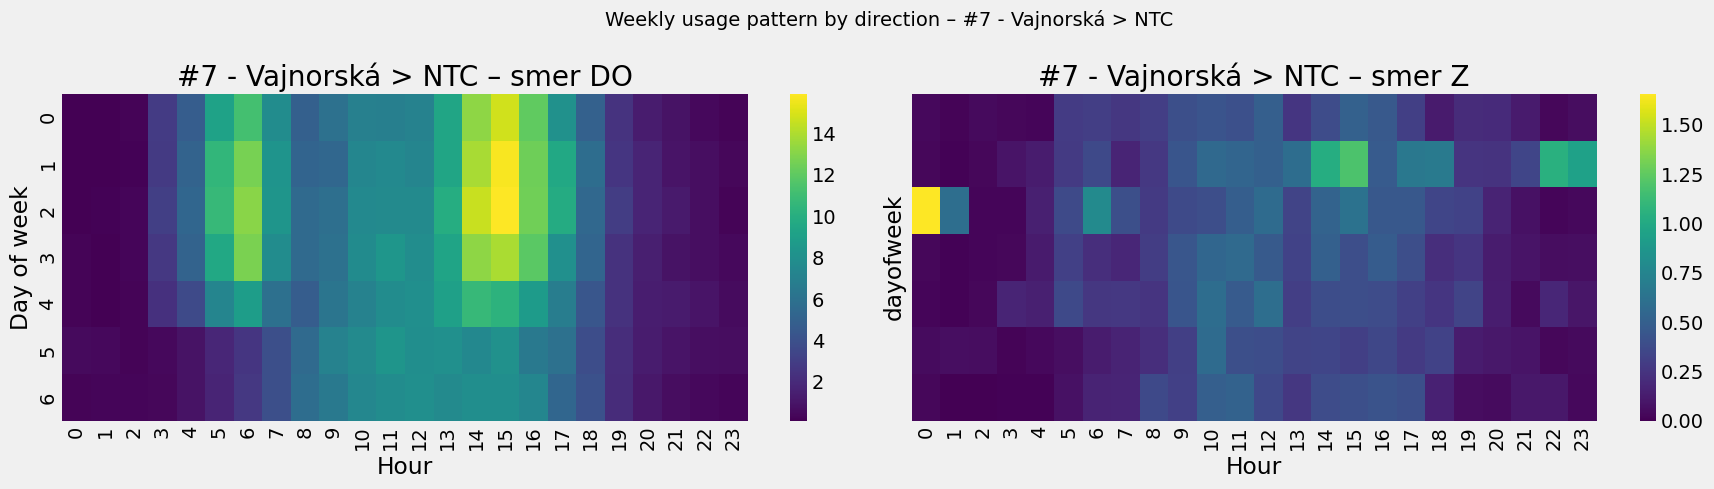

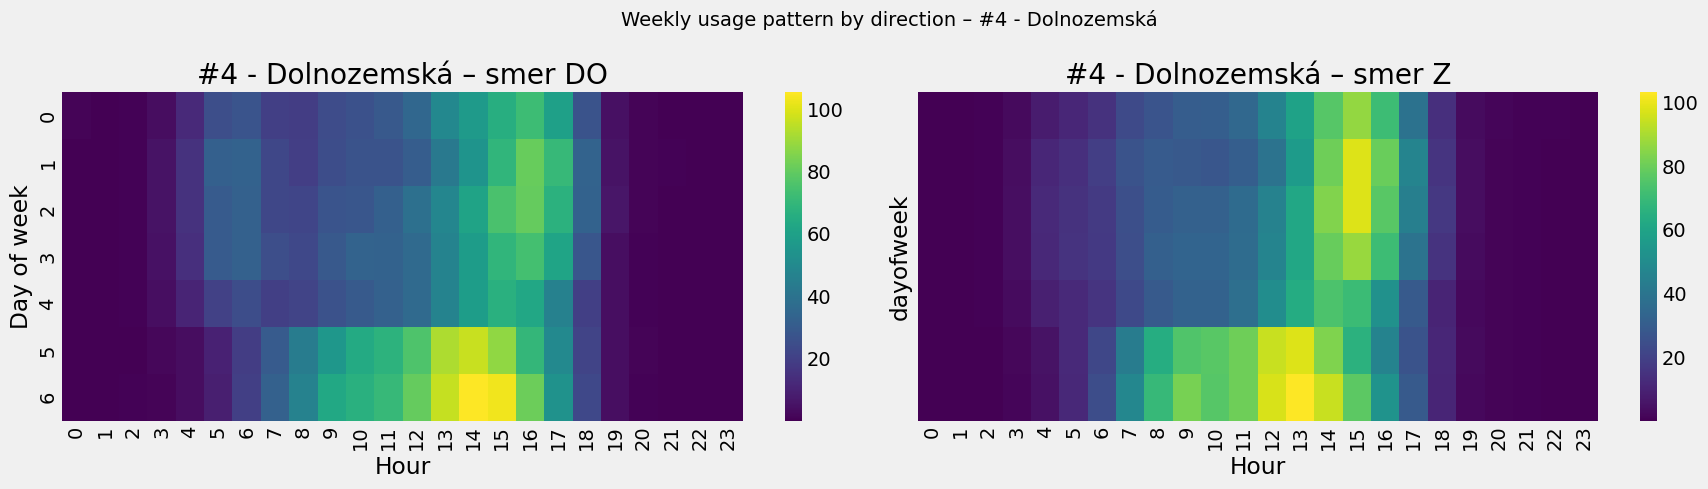

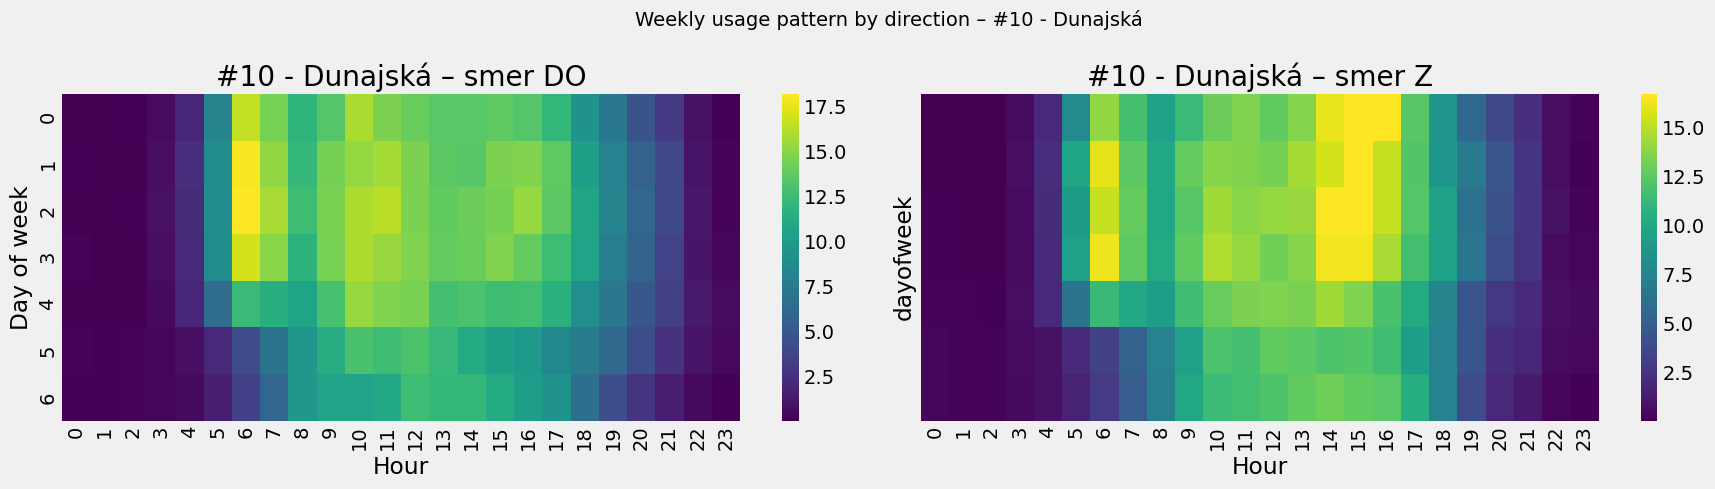

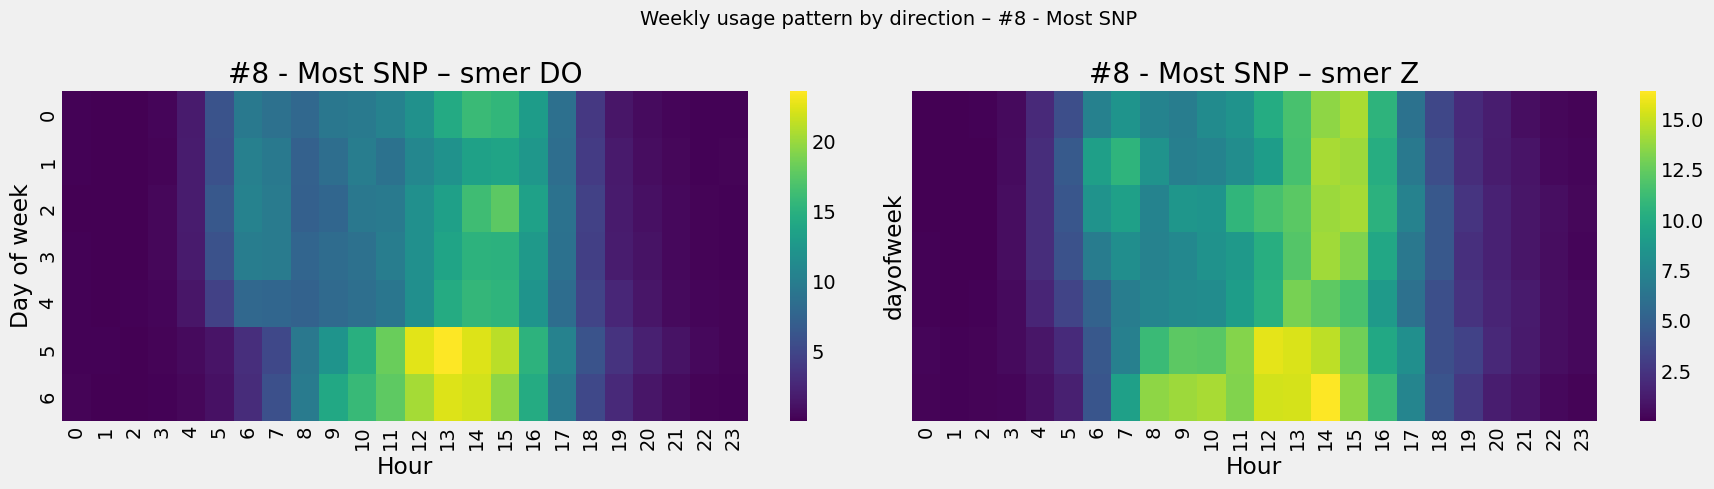

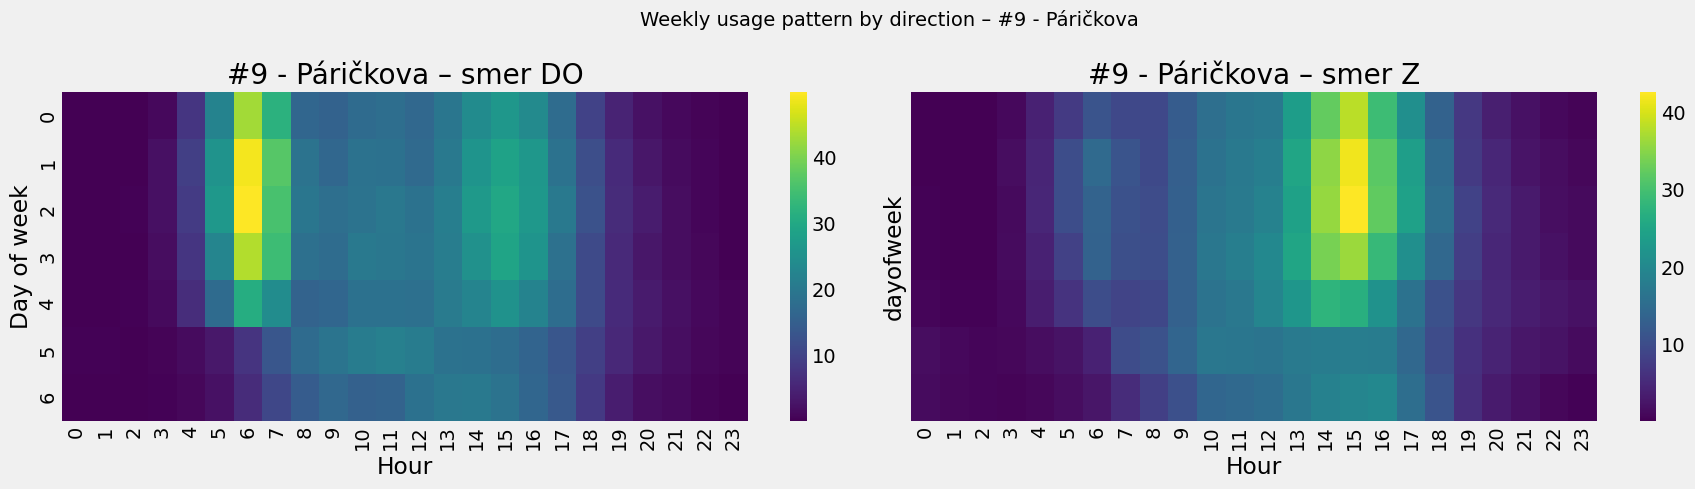

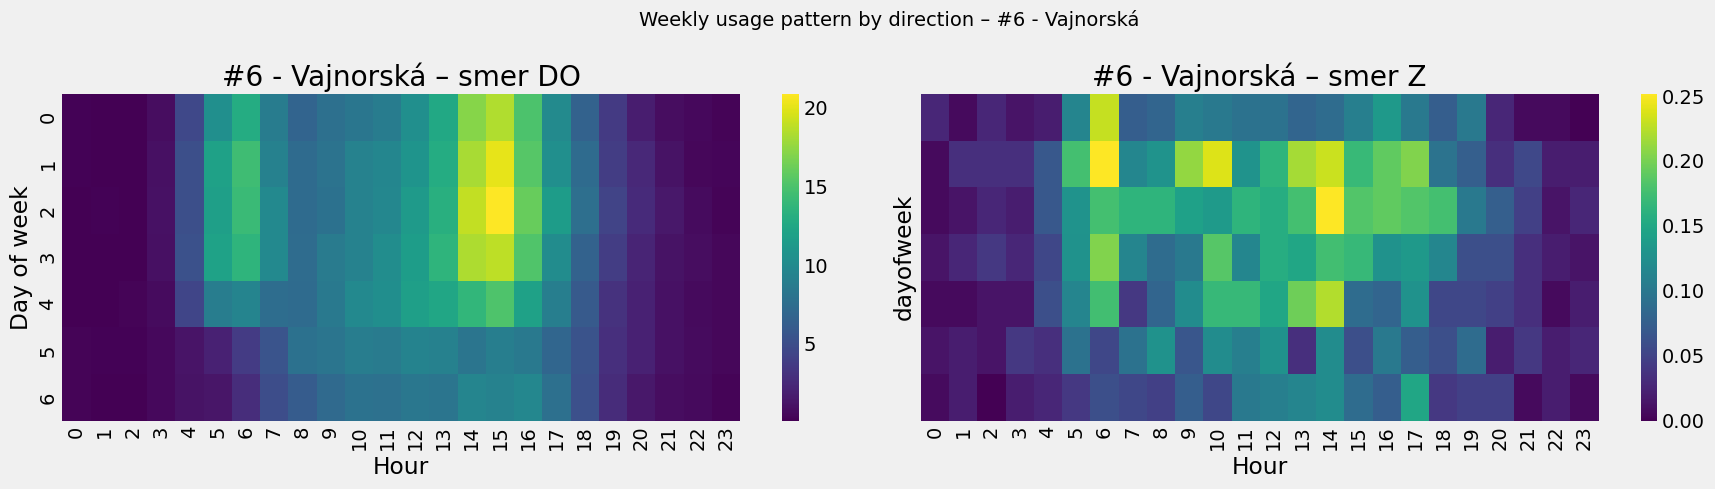

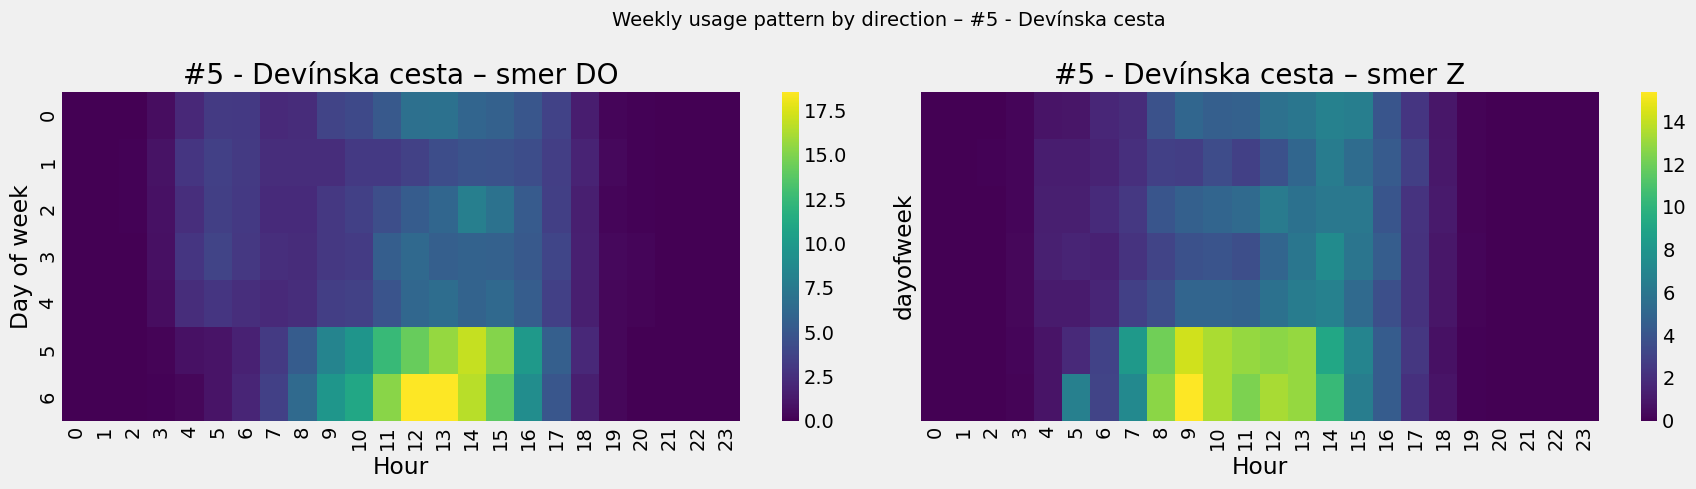

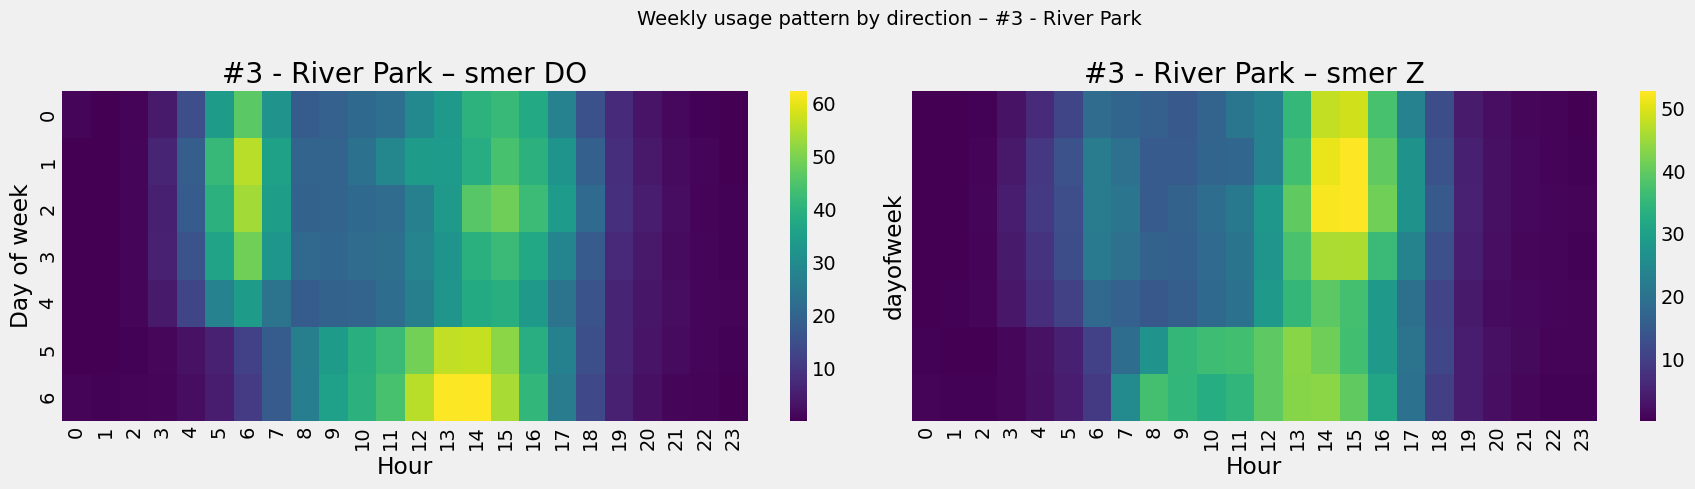

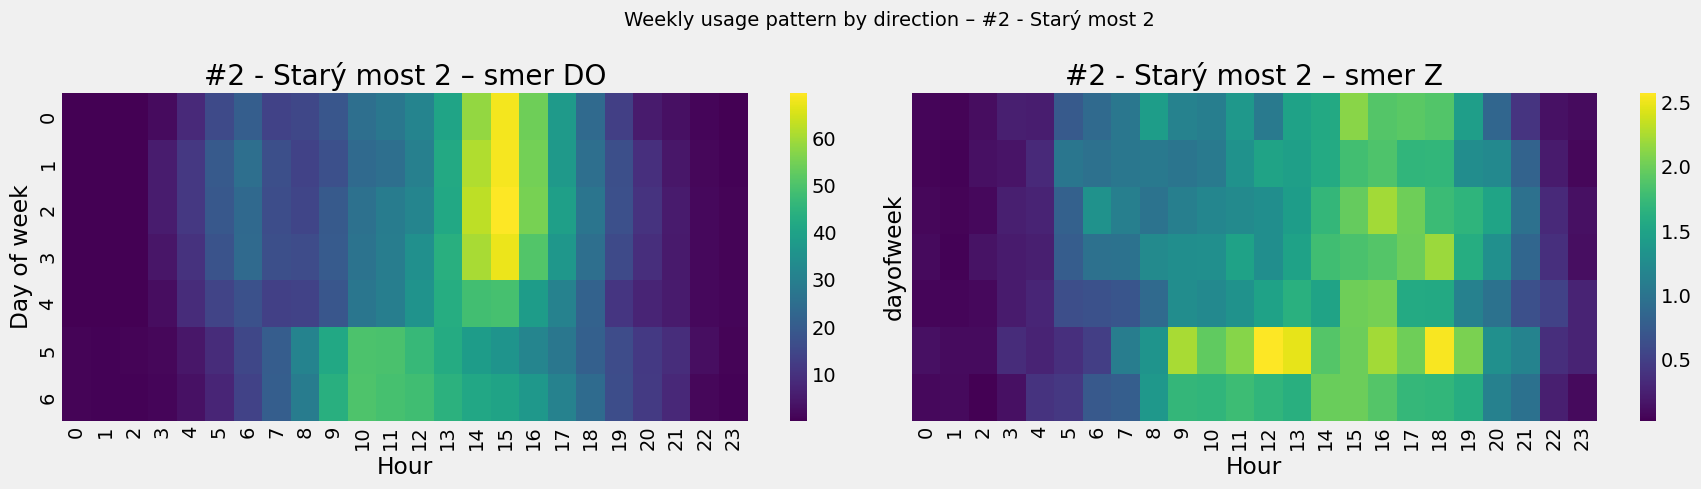

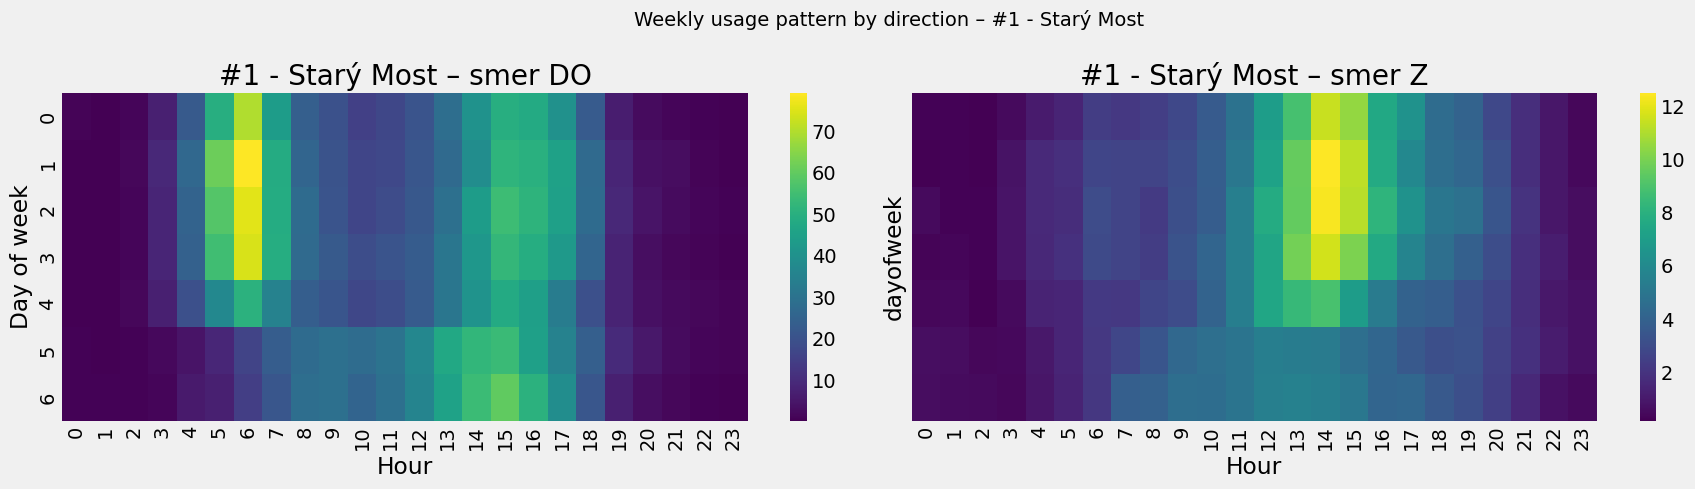

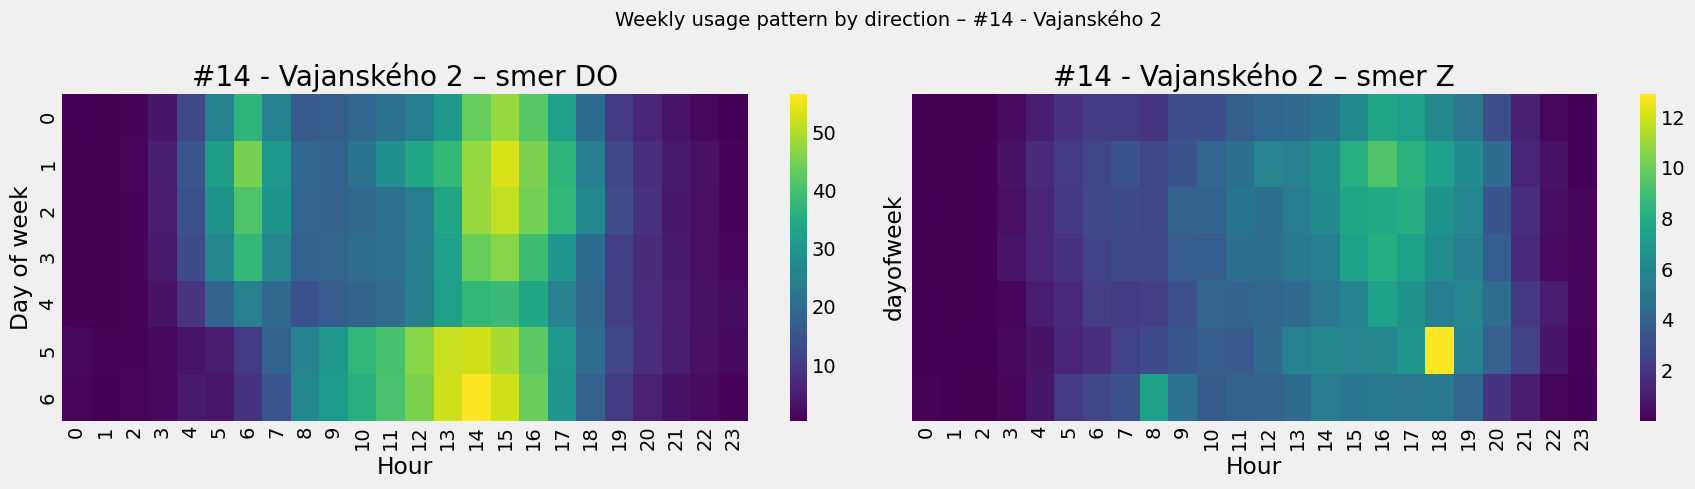

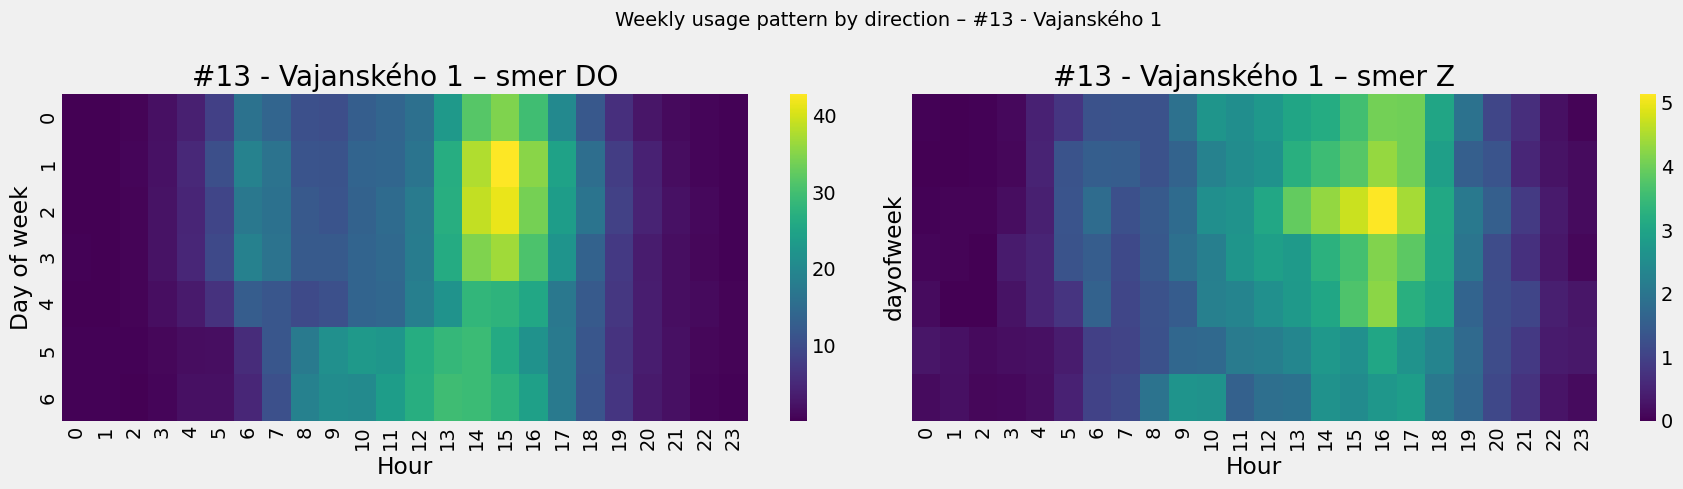

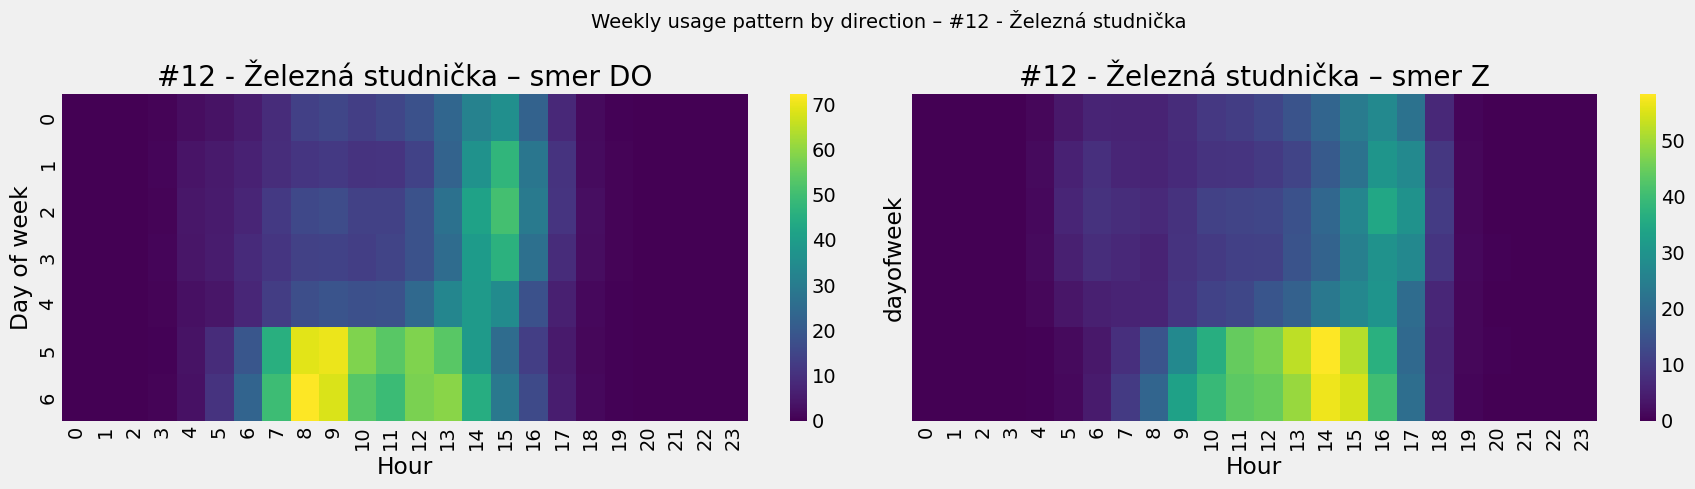

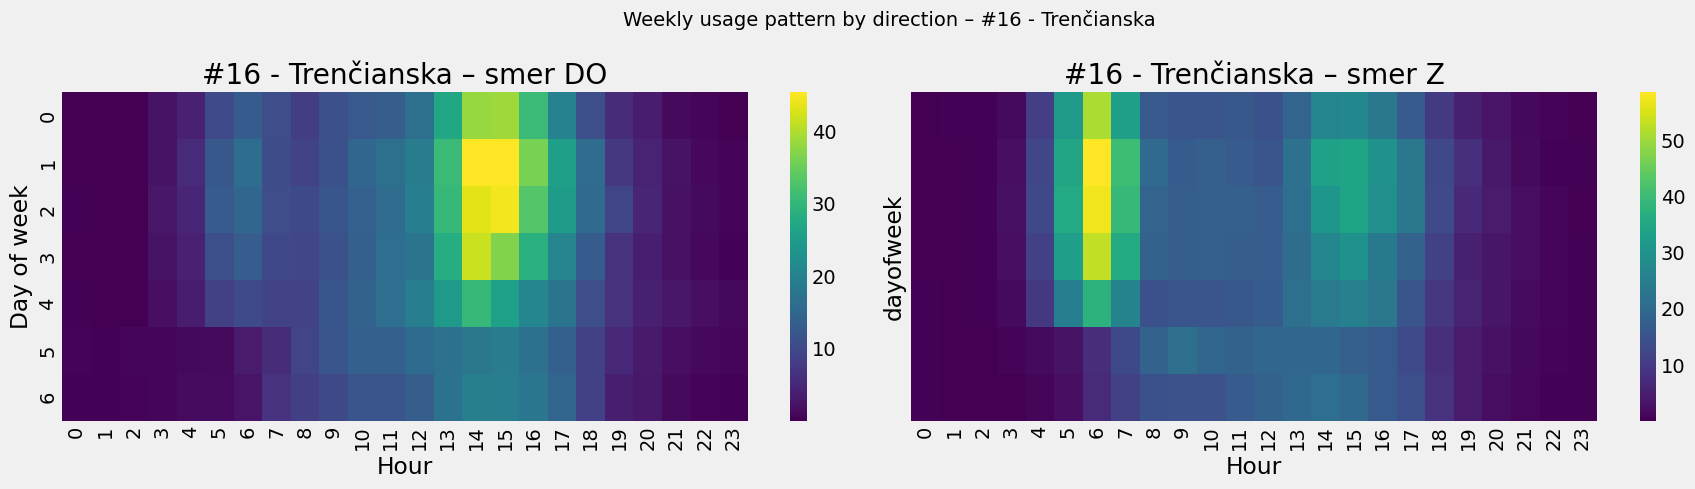

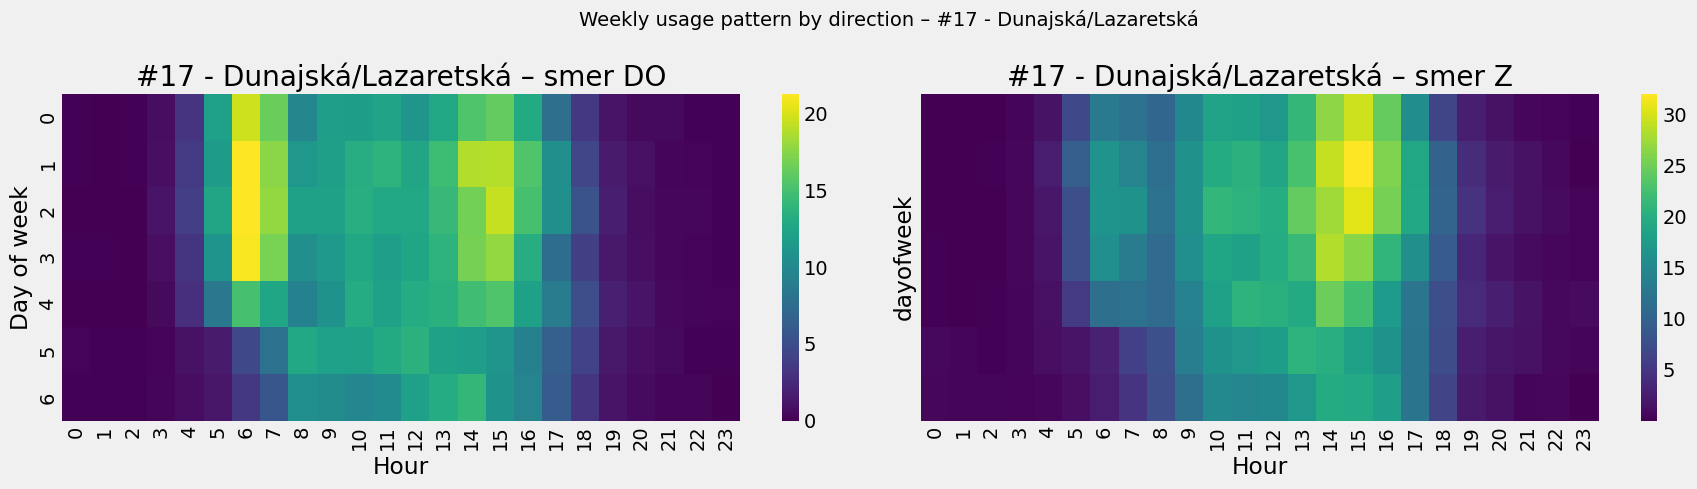

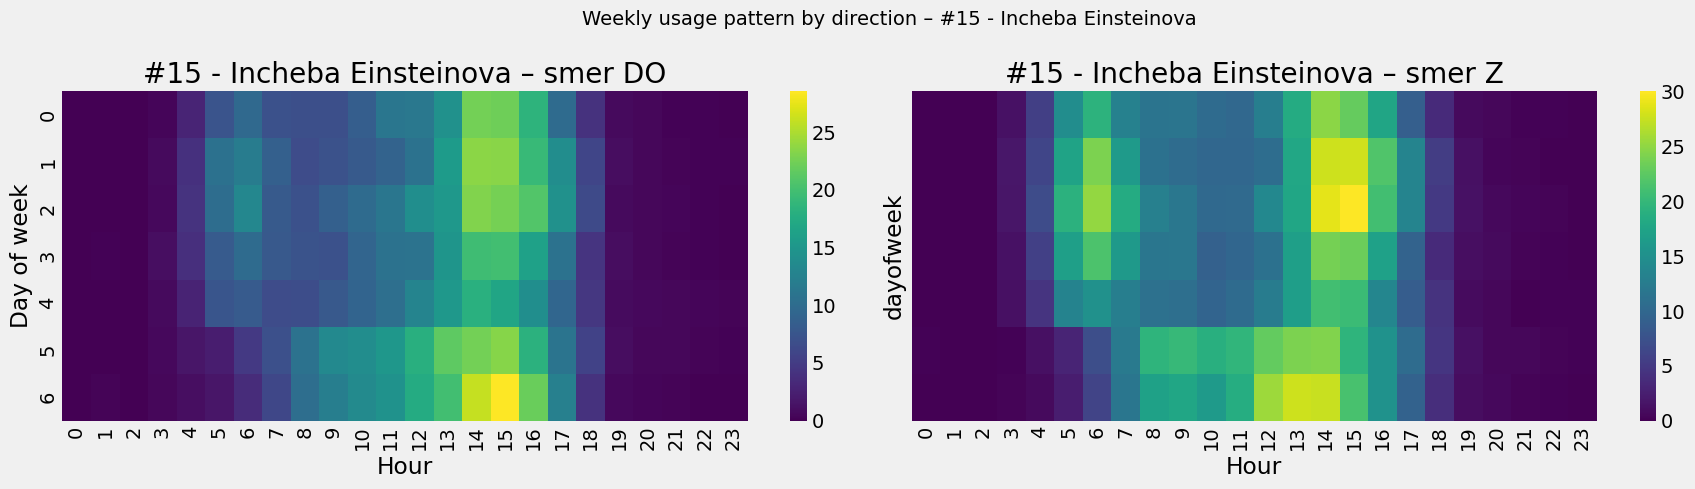

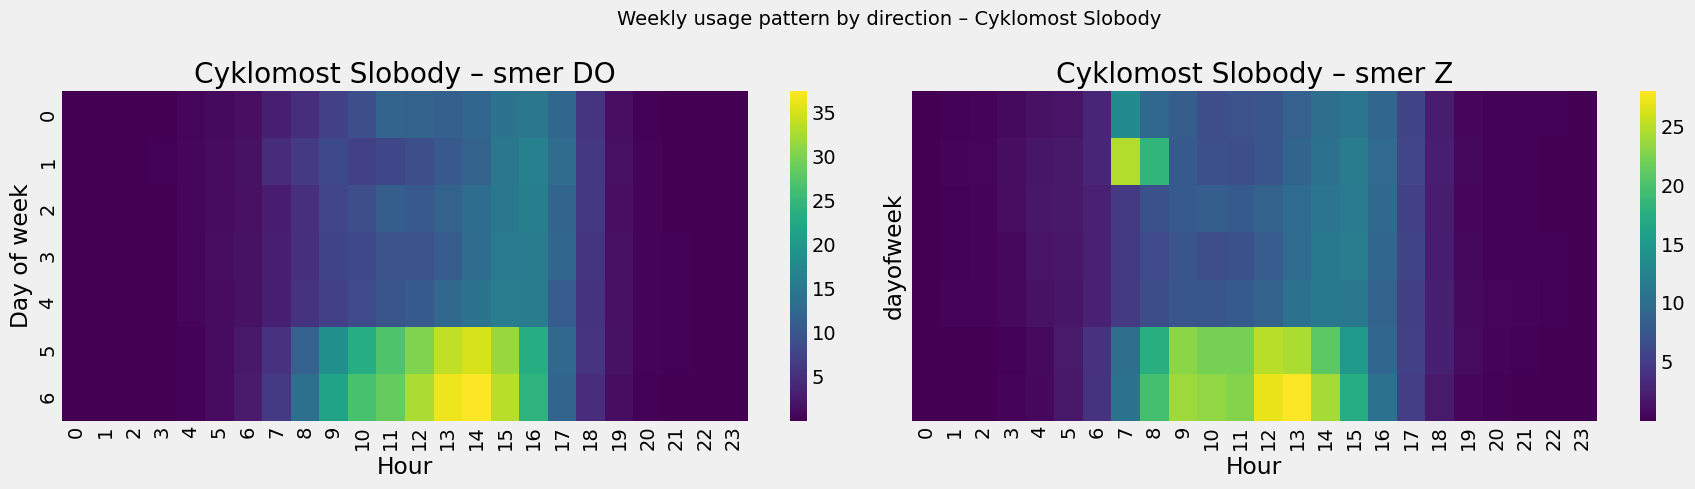

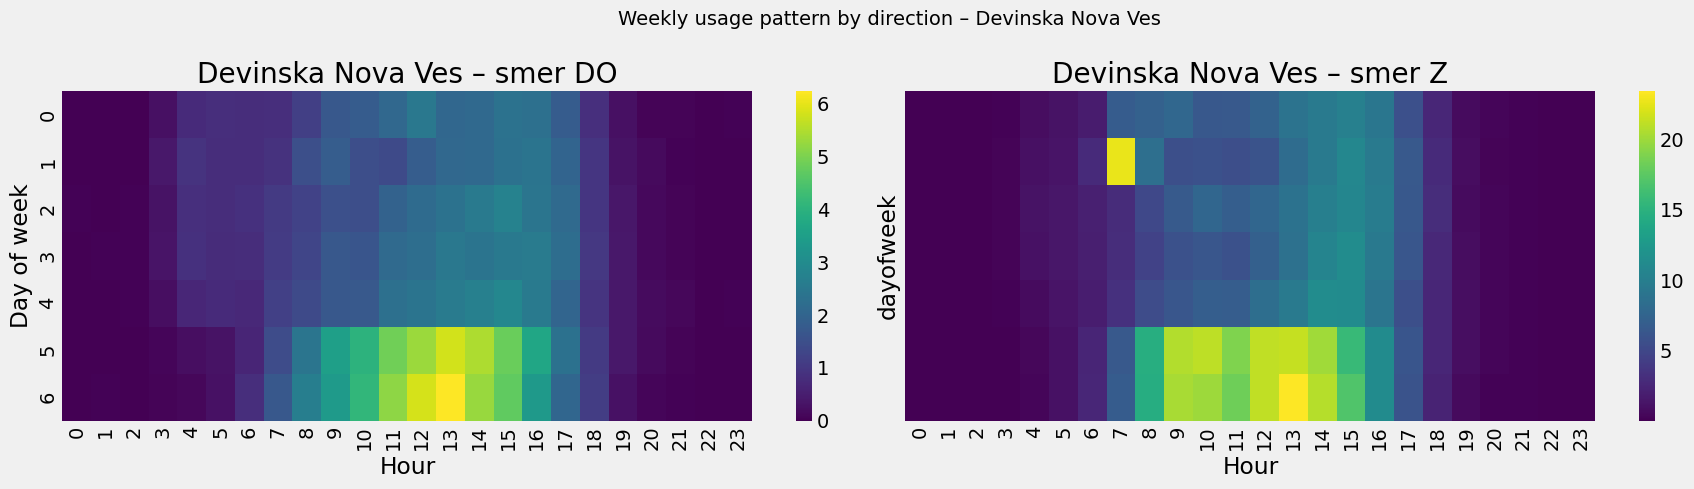

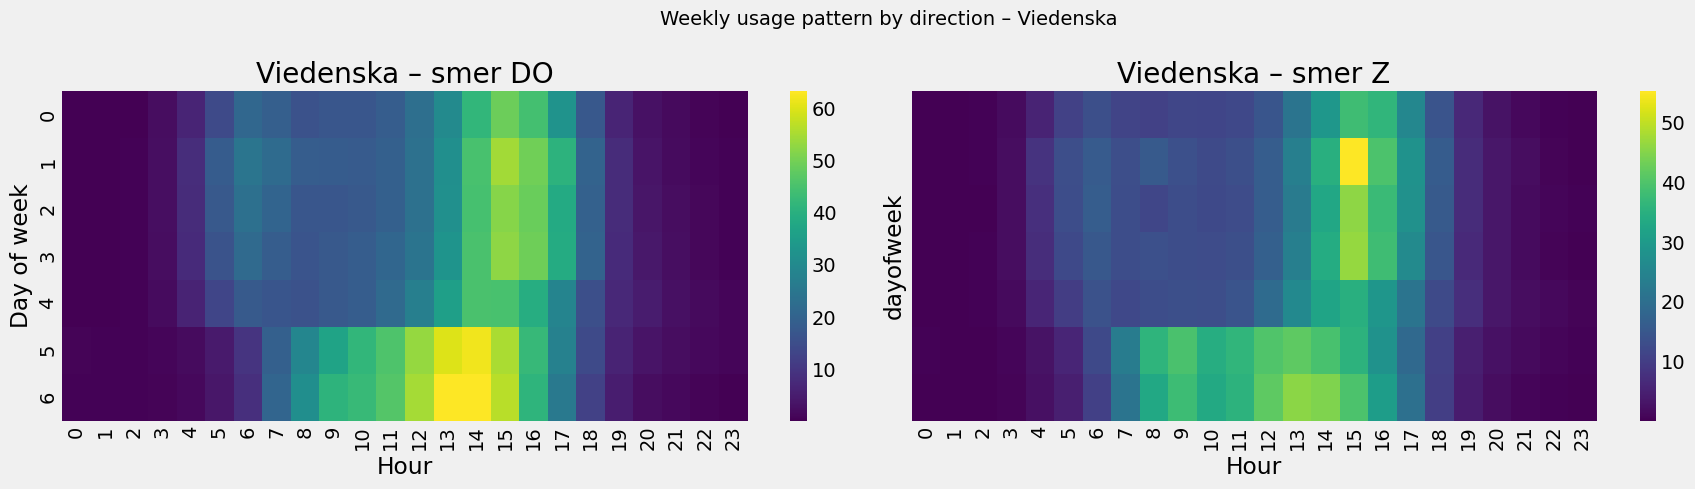

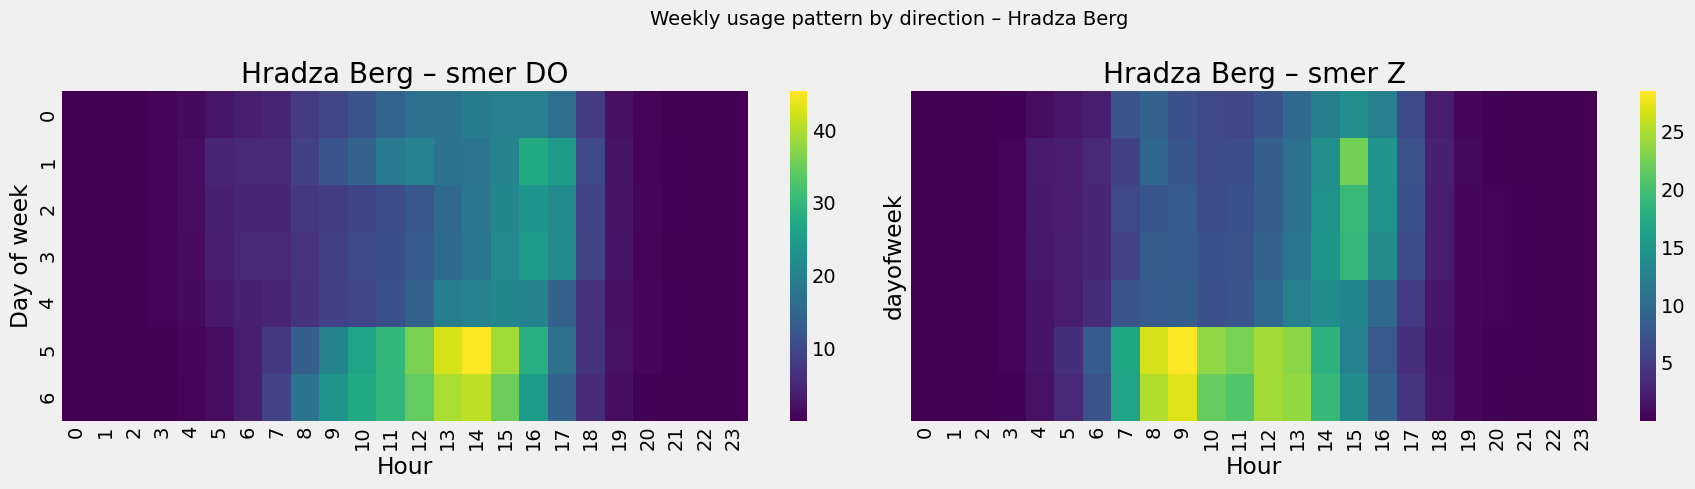

In [ ]:
for route in data_with_features["name"].unique():
    subset = data_with_features[data_with_features["name"] == route]

    pivot_do = (
        subset
        .groupby(["dayofweek", "hour"])["direction_to"]
        .mean()
        .unstack()
    )

    pivot_z = (
        subset
        .groupby(["dayofweek", "hour"])["direction_from"]
        .mean()
        .unstack()
    )

    fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True)

    sns.heatmap(pivot_do, ax=axes[0], cmap="viridis")
    axes[0].set_title(f"{route} – smer DO")
    axes[0].set_xlabel("Hour")
    axes[0].set_ylabel("Day of week")

    sns.heatmap(pivot_z, ax=axes[1], cmap="viridis")
    axes[1].set_title(f"{route} – smer Z")
    axes[1].set_xlabel("Hour")

    plt.suptitle(f"Weekly usage pattern by direction – {route}", fontsize=14)
    plt.tight_layout()
    plt.show()

### Symmetry

In [43]:
direction_balance = (
    data_with_features
    .groupby("name")[["direction_to", "direction_from"]]
    .sum()
)

direction_balance["ratio"] = (
    direction_balance["direction_to"] / direction_balance["direction_from"]
)

direction_balance.sort_values('ratio')


direction_to  direction_from      ratio
name                                                              
Devinska Nova Ves                 69419          263143   0.263807
#17 - Dunajská/Lazaretská         53951           73409   0.734937
#15 - Incheba Einsteinova         55460           68881   0.805157
#16 - Trenčianska                 82060          100680   0.815058
#4 - Dolnozemská                 785188          800655   0.980682
#10 - Dunajská                   193575          182202   1.062420
#5 - Devínska cesta               76354           70505   1.082959
#8 - Most SNP                    165183          142890   1.156015
#9 - Páričkova                   318047          272417   1.167501
Cyklomost Slobody                660625          545545   1.210945
#11 - Most Apollo                194858          159240   1.223675
#3 - River Park                  576058          461023   1.249521
#12 - Železná studnička          334460          258901   1.291845
Viedenska                       1716766         1317819   1.302733
Hradza Berg                      859766          575913   1.492875
#14 - Vajanského 2               323451           54025   5.987062
#1 - Starý Most                  641930          100841   6.365764
#13 - Vajanského 1               198651           26904   7.383698
#7 - Vajnorská > NTC             122635            6736  18.205909
#2 - Starý most 2                499824           25277  19.773866
#6 - Vajnorská                   159757            2168  73.688653

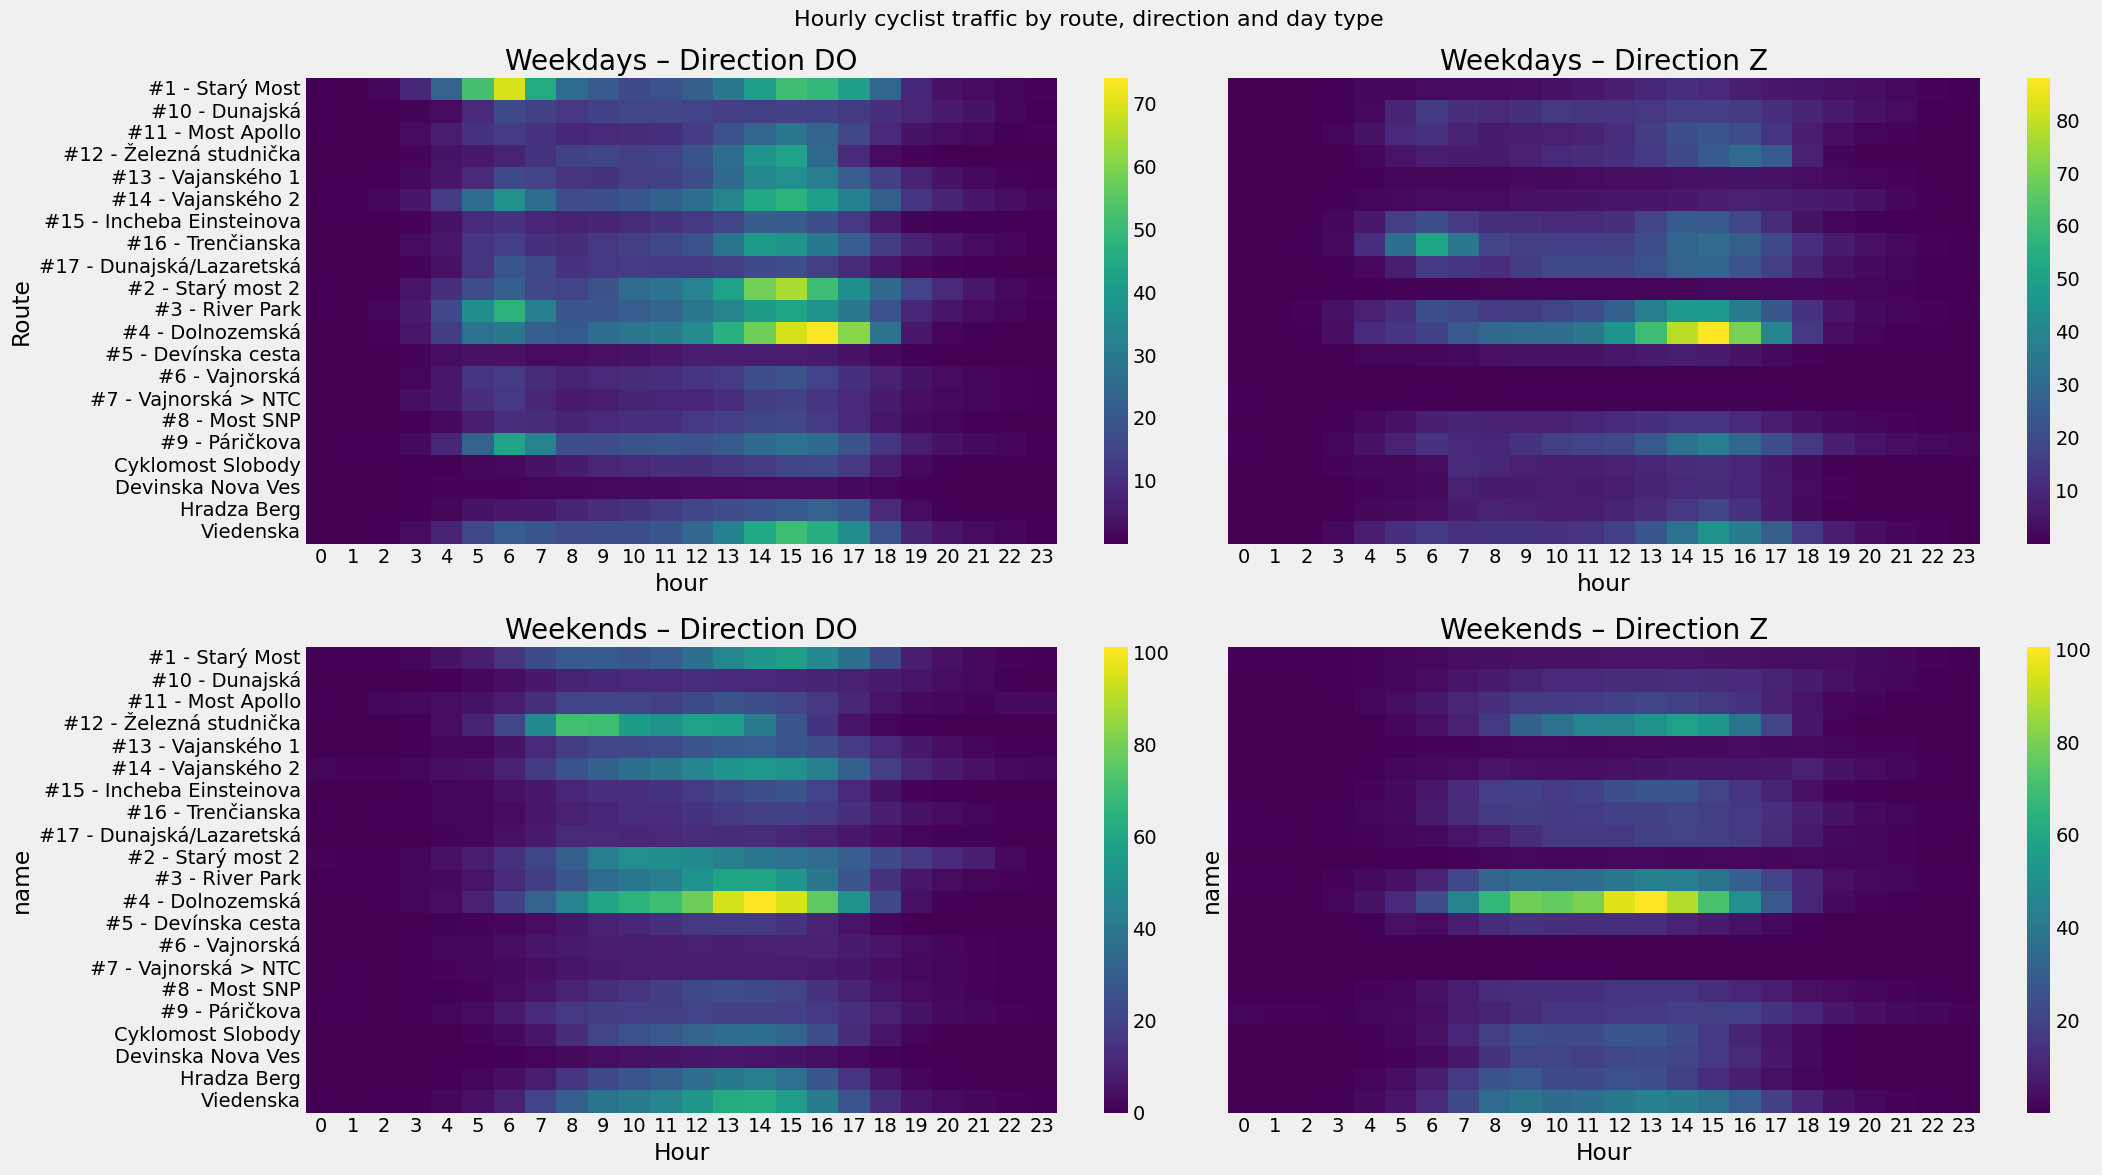

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(22, 12), sharey=True)

# WEEKDAYS
pivot_weekday_do = (
    data_with_features[data_with_features["is_weekend"] == 0]
    .groupby(["name", "hour"])["direction_to"]
    .mean()
    .unstack()
)

pivot_weekday_z = (
    data_with_features[data_with_features["is_weekend"] == 0]
    .groupby(["name", "hour"])["direction_from"]
    .mean()
    .unstack()
)

# WEEKENDS
pivot_weekend_do = (
    data_with_features[data_with_features["is_weekend"] == 1]
    .groupby(["name", "hour"])["direction_to"]
    .mean()
    .unstack()
)

pivot_weekend_z = (
    data_with_features[data_with_features["is_weekend"] == 1]
    .groupby(["name", "hour"])["direction_from"]
    .mean()
    .unstack()
)

sns.heatmap(pivot_weekday_do, cmap="viridis", ax=axes[0, 0])
axes[0, 0].set_title("Weekdays – Direction DO")
axes[0, 0].set_ylabel("Route")

sns.heatmap(pivot_weekday_z, cmap="viridis", ax=axes[0, 1])
axes[0, 1].set_title("Weekdays – Direction Z")
axes[0, 1].set_ylabel("")

sns.heatmap(pivot_weekend_do, cmap="viridis", ax=axes[1, 0])
axes[1, 0].set_title("Weekends – Direction DO")
axes[1, 0].set_xlabel("Hour")

sns.heatmap(pivot_weekend_z, cmap="viridis", ax=axes[1, 1])
axes[1, 1].set_title("Weekends – Direction Z")
axes[1, 1].set_xlabel("Hour")

plt.suptitle("Hourly cyclist traffic by route, direction and day type", fontsize=16)
plt.tight_layout()
plt.show()

C:\Users\Uzivatel\AppData\Local\Temp\ipykernel_13980\2097029818.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["direction_to"] - x["direction_from"]).mean())
C:\Users\Uzivatel\AppData\Local\Temp\ipykernel_13980\2097029818.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["direction_to"] - x["direction_from"]).mean())


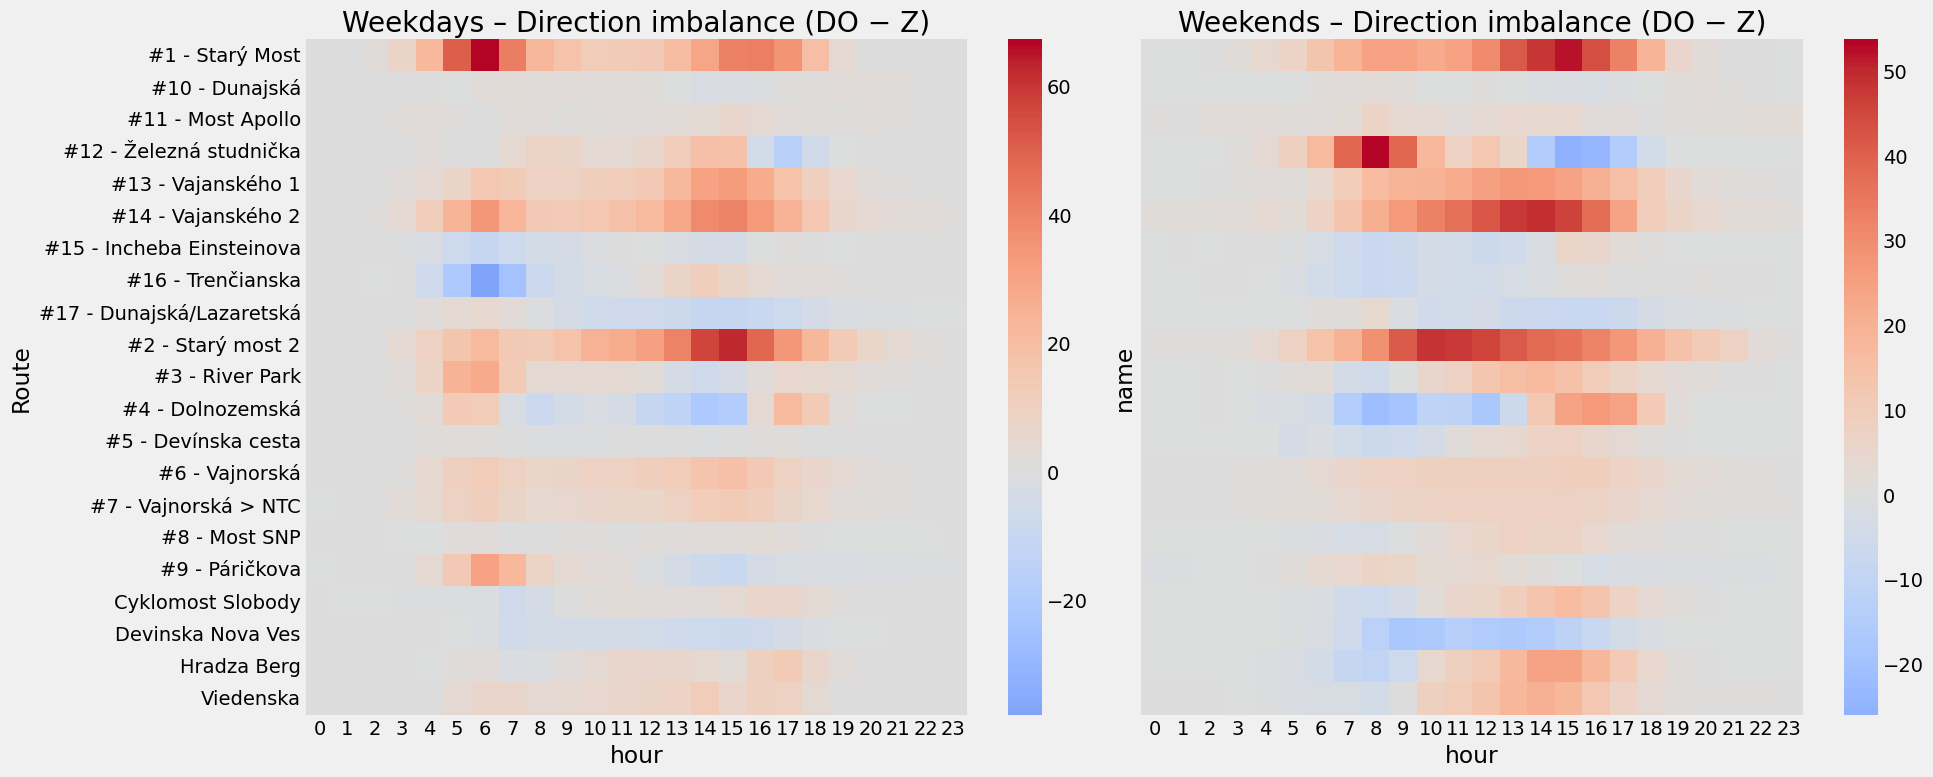

In [ ]:
pivot_diff_weekday = (
    data_with_features[data_with_features["is_weekend"] == 0]
    .groupby(["name", "hour"])
    .apply(lambda x: (x["direction_to"] - x["direction_from"]).mean())
    .unstack()
)

pivot_diff_weekend = (
    data_with_features[data_with_features["is_weekend"] == 1]
    .groupby(["name", "hour"])
    .apply(lambda x: (x["direction_to"] - x["direction_from"]).mean())
    .unstack()
)

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

sns.heatmap(pivot_diff_weekday, cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("Weekdays – Direction imbalance (DO − Z)")
axes[0].set_ylabel("Route")

sns.heatmap(pivot_diff_weekend, cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("Weekends – Direction imbalance (DO − Z)")

plt.tight_layout()
plt.show()


In [ ]:
#TODO: zima vs leto